# 3D tracers with restoring (no_coarse_grain)

We had initially run some simulations where tracers were restarted every month. However, I think this was not long enough. This is partially supported by the zonal channel where diffusivity tensor estimated at the end of two months was quite bad at reproducting buoyancy fluxes. So, it would seem that 1 month (in a simulation where eddy energies and mean flow are weaker) would not do a great job. We actually discovered this too. This is the final test, where a long stabalized restored tracer is used. 

- How diabatic are the fluxes? Obviously the mesoscale doesn't cause diabatic flux. Does it when we coarse grain?
  Check in a small region, with and without averaging. The reason to check this because the buoyancy fluxes are not being recreated properly using only the antisym part of the tensor.
  
- What fraction of the buoyancy flux is being recreated by the A vs the S part?
- What fraction is being recreated by the psi3 part?
  
- The good correspondence between recreated PV flux and that from buoyancy fluxes might be resulting due to small variation is diffusivities below ~1000m. 

## Signficant errors are present, potentially due to no sufficient statistics. 

In [ ]:
# load modules 

import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm
%matplotlib inline
import os 
from xgcm import Grid
from xarrayutils import aggregate
import copy
# Pseudo Inversion 
from scipy.linalg import pinv, eig

In [52]:
from dask.diagnostics import ProgressBar

In [16]:
data_dir = '/swot/SUM04/dbalwada/channel_model/05km/run_multi_tracer_restored_all_tracers/'

# 
model_vars = ['uVeltave','vVeltave','wVeltave', 'Ttave', 
             'UTtave', 'VTtave','WTtave','UUtave', 'UVtave', 'VVtave', 'TTtave']
ds_model = open_mdsdataset(data_dir , delta_t=300,  
                          prefix=model_vars,
                          ignore_unknown_vars=True, geometry='cartesian')

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xmitgcm-0.2.2-py3.6.egg/xmitgcm/utils.py:423: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


In [17]:
data_dir = '/swot/SUM04/dbalwada/channel_model/05km/run_multi_tracer_restored_all_tracers/'

# brief comment on how often was the model data saved 
# the mode outputs fields every 5 days, averages are also
# calculated over 5 days (*this creates stupid amounts of 
# unnecessary data, and was definitely a terrible idea in hidsight).
# 

model_vars = ['tracer1_diag', 'tracer2_diag', 'tracer3_diag', 'tracer4_diag', 'tracer5_diag',
              'tracer6_diag', 'tracer7_diag', 'tracer8_diag', 'tracer9_diag', 'tracer10_diag',
              'tracer11_diag', 'tracer12_diag', 'tracer13_diag', 'tracer14_diag', 'tracer15_diag',
              'tracer16_diag', 'tracer17_diag', 'tracer18_diag', 'tracer19_diag', 'tracer20_diag',]
ds_tracers = open_mdsdataset(data_dir , delta_t=300,  
                          prefix=model_vars,
                          ignore_unknown_vars=True, geometry='cartesian')

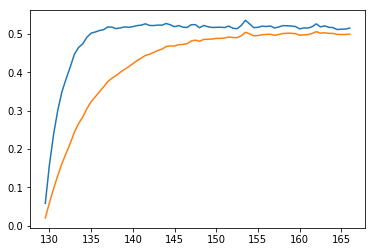

In [21]:

plt.plot(ds_tracers.time/3600/24/360, ds_tracers.TRAC01.sel(Z=-1000, 
                                            method='nearest').sel(XC=slice(0,500e3), 
                                            YC=slice(750e3,1250e3)).mean(['XC','YC']))

plt.plot(ds_tracers.time/3600/24/360, ds_tracers.TRAC02.sel(Z=-1000, 
                                              method='nearest').sel(XC=slice(0,500e3), 
                                               YC=slice(750e3,1250e3)).mean(['XC','YC']))
#ds_tracers.TRAC02.sel(Z=-1000, method='nearest').sel(XC=slice(0,200e3), YC=slice(900e3,1100e3)).mean(['XC','YC']).plot()

In [6]:
list_trac = ['TRAC01', 'TRAC02', 'TRAC03', 'TRAC04', 'TRAC05', 
            'TRAC06', 'TRAC07', 'TRAC08', 'TRAC09', 'TRAC10', 
            'TRAC11', 'TRAC12', 'TRAC13', 'TRAC14', 'TRAC15', 
            'TRAC16', 'TRAC17', 'TRAC18', 'TRAC19', 'TRAC20']

# Tracers for 3D setup (with ridge in the middle.)
$$C1 = yg/Lx$$
$$C2 = (-zg)/H$$
$$C3 = cos(2 \pi x/Lx) $$
$$C4 = sin(2 \pi x/Lx)$$
$$C5 = sin(4 \pi x/Lx)$$
$$C6 = sin( \pi y/Lx)$$
$$C7 = cos(2 \pi y /Lx)$$
$$C8 = sin(2 \pi y/Lx)$$
$$C9 = cos( \pi z/H)$$
$$C10 = sin( \pi z/H)$$

There are 20 tracers, because the tracers are restored with 2 time scales. 2 year and 6 year time scales. 

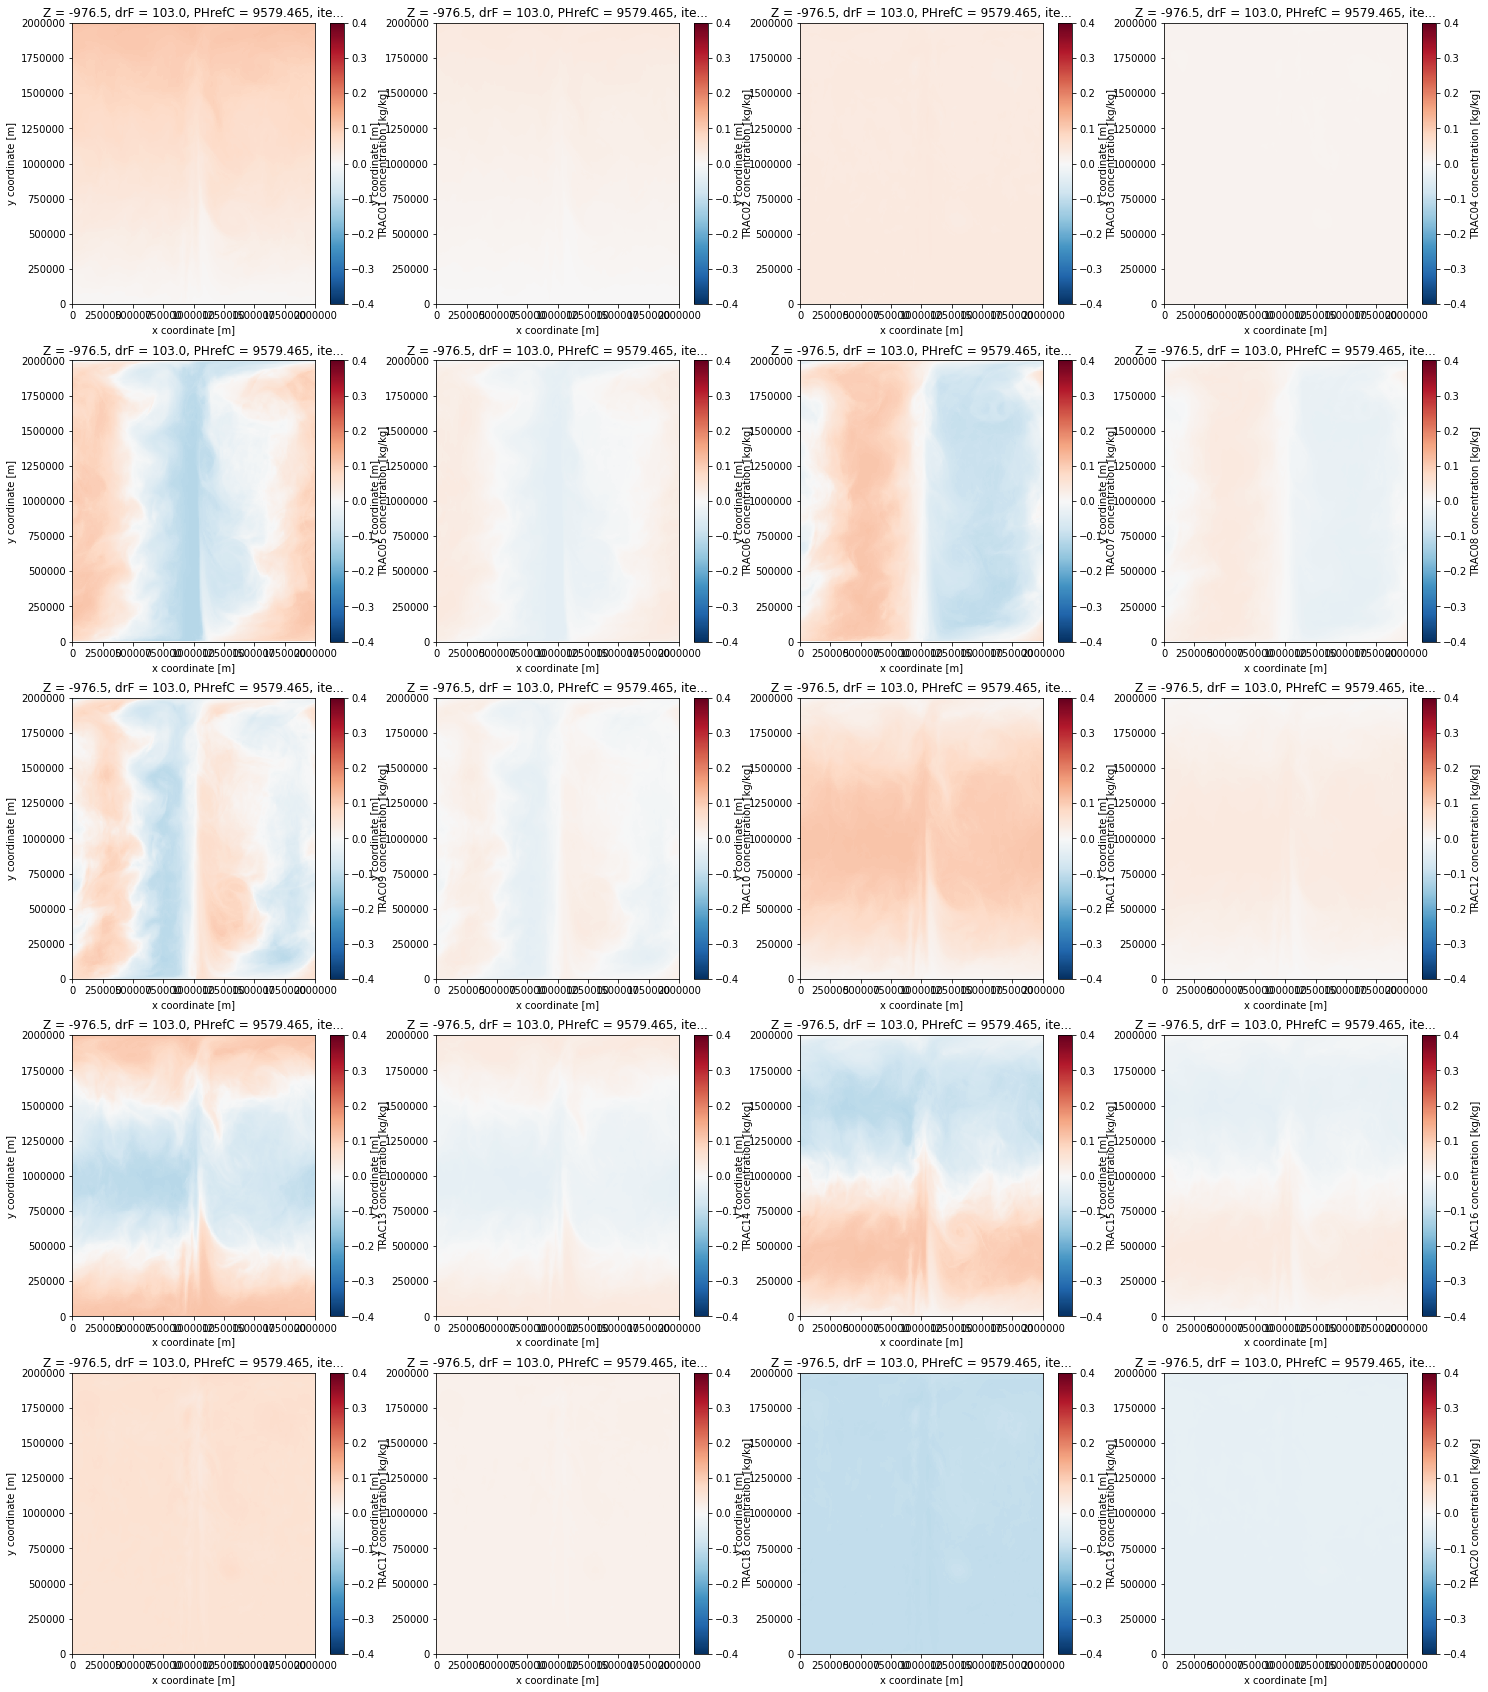

In [45]:
plt.figure(figsize=(25,30))
n=1
for i in list_trac:
    plt.subplot(5,4,n)
    n+=1
    ds_tracers[i].sel(Z=-1000,method='nearest').isel(time=0).plot(vmin=-0.4, vmax=0.4, cmap='RdBu_r')

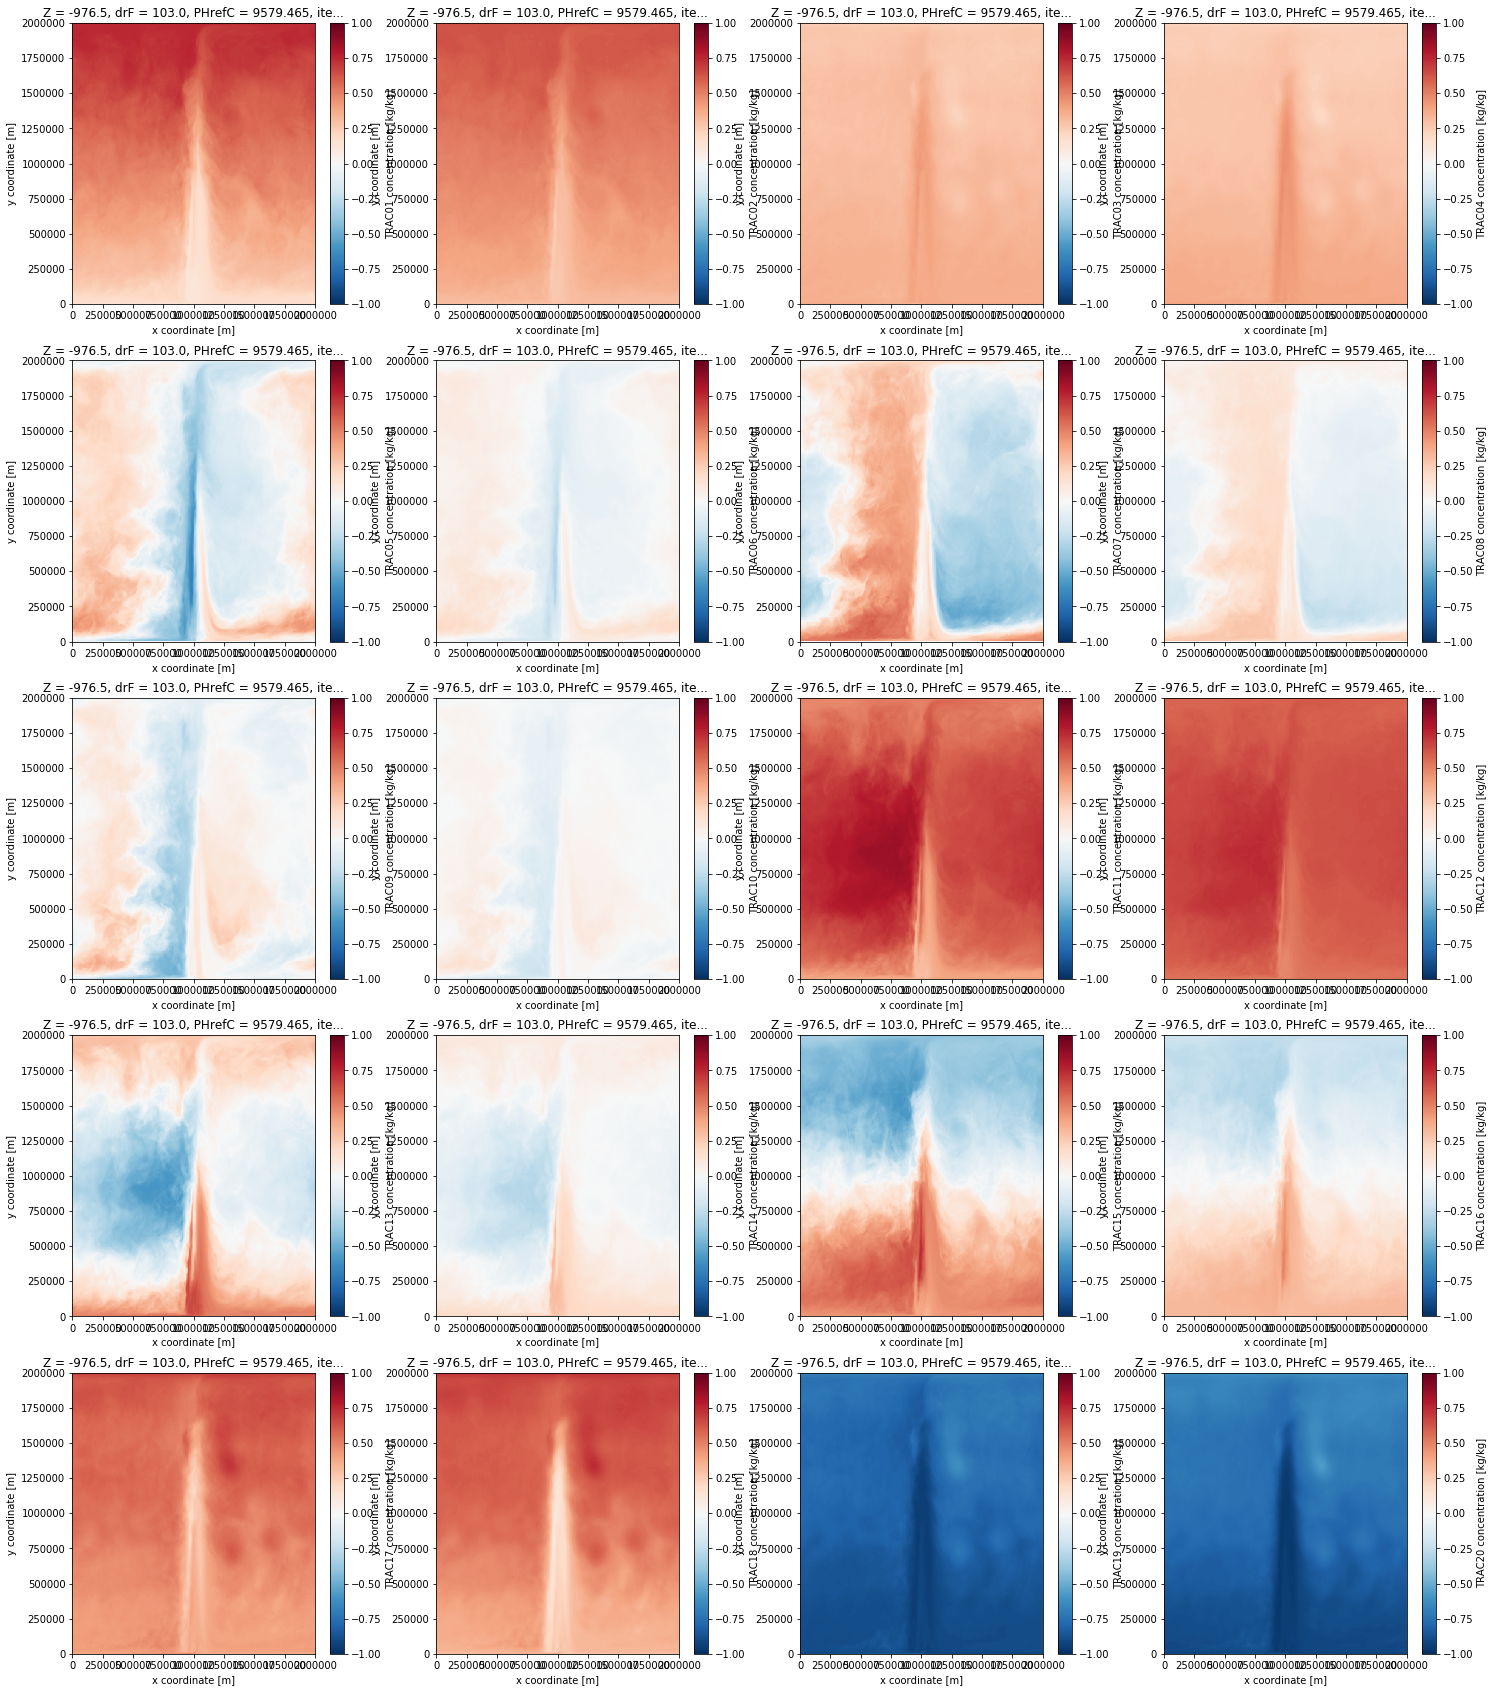

In [9]:
plt.figure(figsize=(25,30))
n=1
for i in list_trac:
    plt.subplot(5,4,n)
    n+=1
    ds_tracers[i].sel(Z=-1000,method='nearest').isel(time=-1).plot(vmin=-1, vmax=1, cmap='RdBu_r')

In [27]:
# Take time averages over appropriate period 
ds_model.time[33]/24/3600/360

<xarray.DataArray 'time' ()>
array(146.)
Coordinates:
    iter     int64 dask.array<shape=(), chunksize=()>
    time     int64 4541184000

In [29]:
Model_Tav = ds_model.isel(time=slice(26,75)).mean('time')

In [30]:
Trac_Tav = ds_tracers.isel(time=slice(26,65)).mean('time')

In [31]:
Model_Tav.load()
Trac_Tav.load()

<xarray.Dataset>
Dimensions:   (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40)
Coordinates:
  * XC        (XC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * YC        (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * XG        (XG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * YG        (YG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * Z         (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2624.5 -2727.5 -2830.5 -2933.5
  * Zp1       (Zp1) >f4 0.0 -10.0 -20.0 -30.0 ... -2779.0 -2882.0 -2985.0
  * Zu        (Zu) >f4 -10.0 -20.0 -30.0 -42.0 ... -2779.0 -2882.0 -2985.0
  * Zl        (Zl) >f4 0.0 -10.0 -20.0 -30.0 ... -2573.0 -2676.0 -2779.0 -2882.0
    rA        (YC, XC) >f4 25000000.0 25000000.0 ... 25000000.0 25000000.0
    dxG       (YG, XC) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    dyG       (YC, XG) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    Depth     (YC, XC) >f4 0.0 

In [12]:
X = Trac_Tav.XC
Y = Trac_Tav.YC
Z = Trac_Tav.Z

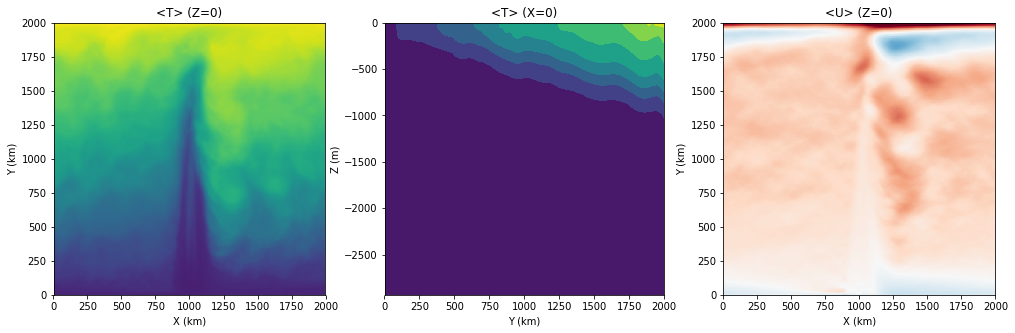

In [13]:
# see what the output looks like. 

fig, ax = plt.subplots(1, 3, figsize=(17, 5))

ax[0].pcolormesh(X/1e3, Y/1e3, ds_model.Ttave.isel(time=-1, Z=0))
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')
ax[0].set_title('<T> (Z=0)')
ax[0].set_aspect('equal')

ax[1].contourf(Y/1e3, Z, ds_model.Ttave.isel(time=-1, XC=0))
ax[1].set_xlabel('Y (km)')
ax[1].set_ylabel('Z (m)')
ax[1].set_title('<T> (X=0)')

ax[2].pcolormesh(X/1e3, Y/1e3, Model_Tav.uVeltave.isel(Z=0), vmin=-0.4, vmax=0.4, cmap='RdBu_r')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Y (km)')
ax[2].set_title('<U> (Z=0)')
ax[2].set_aspect('equal')

In [14]:
list_tracers = ['TRAC01', 'TRAC02','TRAC03','TRAC04','TRAC05',
                'TRAC06','TRAC07','TRAC08','TRAC09','TRAC10',
                'TRAC11', 'TRAC12','TRAC13','TRAC14','TRAC15',
                'TRAC16','TRAC17','TRAC18','TRAC19','TRAC20']

list_vels = ['uVeltave','vVeltave','wVeltave']
vels = {'uVeltave':'U', 'vVeltave':'V', 'wVeltave':'W'}

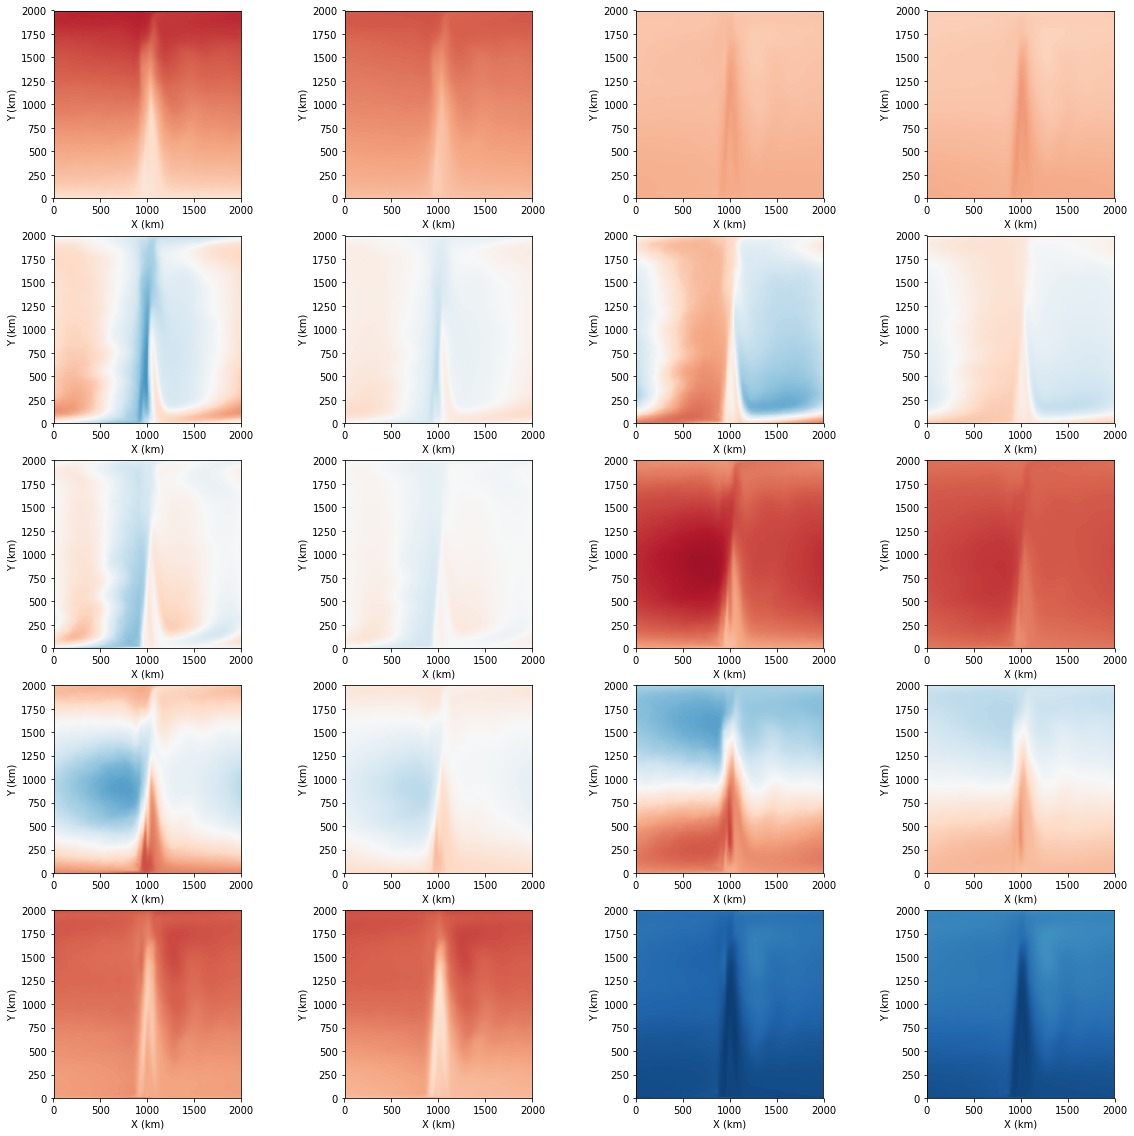

In [32]:
fig, ax = plt.subplots(5, 4, figsize=(20, 20), squeeze=True)
axf = ax.flatten()
n=0
for key in list_tracers: 
    axf[n].pcolormesh(X/1e3, Y/1e3, Trac_Tav[key].sel(Z=-1000, method='nearest'), 
                      vmin=-1, vmax=1, cmap='RdBu_r')
    axf[n].set_xlabel('X (km)')
    axf[n].set_ylabel('Y (km)')
    axf[n].set_aspect('equal')
    
    n+=1
    
#fig.suptitle('<Tracers> (Z=0)')

Lets get into the meat

In [20]:
# Define the coarse grid

#Lcoarse = 100e3 # needs to be a multiple of the domain size.
#idmax   = int( (Model_Tav.dyC[0,0].values * len(Model_Tav.YC))/Lcoarse) # numper of grid points to average over
#nreps   = int( len(Model_Tav.YC)/idmax )

#YCicoarse = np.repeat(range(idmax),nreps)
#XCicoarse = np.repeat(range(idmax),nreps)

In [33]:
grid = Grid(Model_Tav, periodic='X')

In [34]:
# Interpolate mean velocities to all be on same point.# Interp 
Model_Tav['WmeanC'] = grid.interp(Model_Tav.wVeltave, 'Z', boundary='extend')
Model_Tav['VmeanC'] = grid.interp(Model_Tav.vVeltave, 'Y', boundary='extend')
Model_Tav['UmeanC'] = grid.interp(Model_Tav.uVeltave, 'X')

In [23]:
#Model_Tav.coords['XCicoarse'] = ('XC', XCicoarse)
#Model_Tav.coords['YCicoarse'] = ('YC', YCicoarse)

In [24]:
# coarse grain mean velocities

#Vels_coarse = xr.Dataset()

#for i in vels:
#    Vels_coarse[vels[i]] = (Model_Tav[vels[i]+'meanC'].groupby('YCicoarse').mean('YC')).groupby('XCicoarse').mean('XC')

#Vels_coarse.coords['YCcoarse'] = ('YCicoarse', Model_Tav.YC.groupby('YCicoarse').mean('YC'))
#Vels_coarse.coords['XCcoarse'] = ('XCicoarse', Model_Tav.XC.groupby('XCicoarse').mean('XC'))

In [35]:
# Move eddy fluxes to center point

for key in list_tracers: 
        Trac_Tav['V'+key] = grid.interp(Trac_Tav['V'+key], 'Y', boundary='extend')
        Trac_Tav['U'+key] = grid.interp(Trac_Tav['U'+key], 'X')

In [26]:
# create coarse grained version of fluxes and mean tracers# create 

#Trac_Tav.coords['YCicoarse'] = ('YC', YCicoarse)
#Trac_Tav.coords['XCicoarse'] = ('XC', XCicoarse)

#Trac_coarse = (Trac_Tav.groupby('YCicoarse').mean('YC')).groupby('XCicoarse').mean('XC')

#Trac_coarse.coords['Ycoarse'] = ('YCicoarse', Trac_Tav.YC.groupby('YCicoarse').mean('YC'))
#Trac_coarse.coords['Xcoarse'] = ('XCicoarse', Trac_Tav.XC.groupby('XCicoarse').mean('XC'))

In [27]:
#Xcoarse = Trac_coarse['Xcoarse']
#Ycoarse = Trac_coarse['Ycoarse']

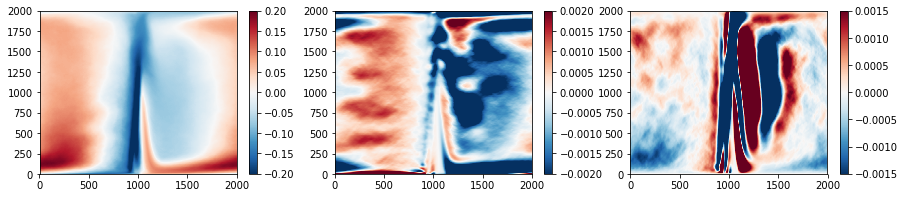

In [37]:
fig, ax = plt.subplots(1,3,figsize=(15,3))

im = ax[0].pcolormesh(X/1e3, Y/1e3, Trac_Tav['TRAC06'].sel(Z=-1000, method='nearest'),
                vmin=-0.2, vmax=0.2, cmap='RdBu_r')
fig.colorbar(im, ax=ax[0])

im =ax[1].pcolormesh(X/1e3, Y/1e3, Trac_Tav['UTRAC06'].sel(Z=-1000, method='nearest'),
                 vmin = -0.002, vmax=0.002, cmap='RdBu_r')
fig.colorbar(im, ax=ax[1])

im = ax[2].pcolormesh(X/1e3, Y/1e3, Trac_Tav['VTRAC06'].sel(Z=-1000, method='nearest'),
                 vmin = -0.0015, vmax=0.0015, cmap='RdBu_r')
fig.colorbar(im, ax=ax[2])

In [38]:
# flux datasets 

for i in list_tracers: 
    Trac_Tav['Up'+i+'p'] = Trac_Tav['U'+i] - Model_Tav['UmeanC'] * Trac_Tav[i]    
    Trac_Tav['Vp'+i+'p'] = Trac_Tav['V'+i] - Model_Tav['VmeanC'] * Trac_Tav[i]
    Trac_Tav['Wp'+i+'p'] = Trac_Tav['W'+i] - Model_Tav['WmeanC'] * Trac_Tav[i]

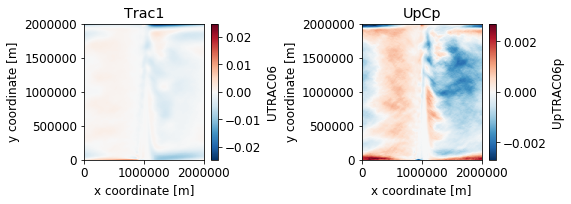

In [39]:

plt.figure(figsize=(8,3))
font = {'size'   : 12}

plt.rc('font', **font)

plt.subplot(121)
Trac_Tav['UTRAC06'].sel(Z=-1000, method='nearest').plot()
plt.title('Trac1')

plt.subplot(122)
Trac_Tav['UpTRAC06p'].sel(Z=-1000, method='nearest').plot()
plt.title('UpCp')

plt.tight_layout()

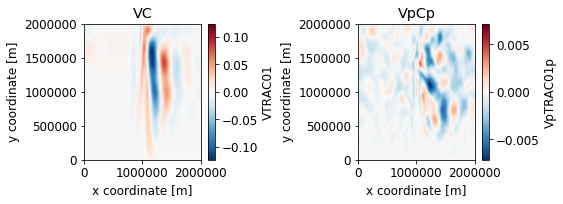

In [40]:
plt.figure(figsize=(8,3))
font = {'size'   : 12}

plt.rc('font', **font)

plt.subplot(121)
Trac_Tav['VTRAC01'].sel(Z=-1000, method='nearest').plot()
plt.title('VC')

plt.subplot(122)
Trac_Tav['VpTRAC01p'].sel(Z=-1000, method='nearest').plot()
plt.title('VpCp')

plt.tight_layout()

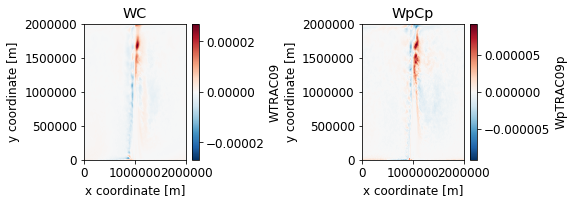

In [42]:
plt.figure(figsize=(8,3))
font = {'size'   : 12}

plt.rc('font', **font)

plt.subplot(121)
Trac_Tav['WTRAC09'].sel(Z=-1000, method='nearest').plot()
plt.title('WC')

plt.subplot(122)
Trac_Tav['WpTRAC09p'].sel(Z=-1000, method='nearest').plot()
plt.title('WpCp')

plt.tight_layout()

In [33]:
# To calculate the tracer gradients we need a staggered coordinate

# make staggered coordinates
#temp = np.repeat(idmax, nreps/2)
#temp2 = np.repeat(idmax-1, nreps/2)
#YSicoarse = np.concatenate([YCicoarse[int(nreps/2):], temp])
#XSicoarse = np.concatenate([temp2, XCicoarse[:-int(nreps/2)]])


In [41]:
# Aux functions (can put into python script)

# Function to calculate the gradients
def tracer_grads(ds, ds_full):
    
    grid = Grid(ds_full, periodic='X')
    
    dx = ds_full.dxC.mean('YC')
    dy = ds_full.dyC.mean('XC')
    dz = ds_full.drF
    
    trac_dx = grid.interp(grid.diff(ds,'X')/dx, 'X')
    
    trac_dy = grid.interp(grid.diff(ds,'Y', boundary = 'extend')/dy, 'Y',boundary='extend')
    
    trac_dz = - grid.interp(grid.diff(ds,'Z', boundary = 'extend'), 'Z',boundary='extend')/dz

    trac_dx= trac_dx.rename('dcdx')
    trac_dy= trac_dy.rename('dcdy')
    trac_dz= trac_dz.rename('dcdz')
    
    grads = xr.merge([trac_dx, trac_dy, trac_dz])
    return grads

In [44]:
# Calculate tracer gradients 
# Tracer gradients of time averaged fields.

Tracgrad_Tav = {}

for k in list_tracers:
    Tracgrad_Tav[k] = tracer_grads(Trac_Tav[k], Trac_Tav)

In [45]:
# Put fluxes into separate xarrays and add dimension corresponding to tracer number
# U'C'
testxr1 = Trac_Tav['UpTRAC01p']
testxr1['tracer_num'] = 1

UpCp = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = Trac_Tav['Up'+i+'p']
    temp['tracer_num'] = n 
    n=n+1
    
    UpCp = xr.concat([UpCp, temp], dim='tracer_num')
       
# V'C'
testxr1 = Trac_Tav['VpTRAC01p']
testxr1['tracer_num'] = 1

VpCp = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = Trac_Tav['Vp'+i+'p']
    temp['tracer_num'] = n 
    n=n+1
    
    VpCp = xr.concat([VpCp, temp], dim='tracer_num')
    
# W'C'
testxr1 = Trac_Tav['WpTRAC01p']
testxr1['tracer_num'] = 1

WpCp = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = Trac_Tav['Wp'+i+'p']
    temp['tracer_num'] = n 
    n=n+1
    
    WpCp = xr.concat([WpCp, temp], dim='tracer_num')

In [47]:
# Put tracer gradients into xarrays
# dCdx
testxr1 = Tracgrad_Tav['TRAC01']['dcdx']
testxr1['tracer_num'] = 1

dCdx = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = Tracgrad_Tav[i]['dcdx']
    temp['tracer_num'] = n 
    n=n+1
    
    dCdx = xr.concat([dCdx, temp], dim='tracer_num')
    
# dCdy
testxr1 = Tracgrad_Tav['TRAC01']['dcdy']
testxr1['tracer_num'] = 1

dCdy = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = Tracgrad_Tav[i]['dcdy']
    temp['tracer_num'] = n 
    n=n+1
    
    dCdy = xr.concat([dCdy, temp], dim='tracer_num')   
    
# dCdz
testxr1 = Tracgrad_Tav['TRAC01']['dcdz']
testxr1['tracer_num'] = 1

dCdz = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = Tracgrad_Tav[i]['dcdz']
    temp['tracer_num'] = n 
    n=n+1
    
    dCdz = xr.concat([dCdz, temp], dim='tracer_num')

In [49]:
# Function to calculate the diffusivity tensor 

def calc_tensor(uc,vc,wc, cx,cy,cz):
    Aflux = np.array([uc, vc, wc])
    Agrad = np.array([cx, cy, cz])


    if ~(np.isnan(Agrad).any() | np.isnan(Aflux).any()):
        return -(Aflux.dot(pinv(Agrad)))
    else:
        return np.nan*(Aflux.dot(Agrad.T))

In [53]:
with ProgressBar():
    2+2

# Use restored tracers, as if there is no restoration. 

In [54]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)

with ProgressBar():
    Ktensor_fast = xr.apply_ufunc(calc_tensor, 
                       UpCp.sel(tracer_num=slice(1,19,2)),
                       VpCp.sel(tracer_num=slice(1,19,2)),
                       WpCp.sel(tracer_num=slice(1,19,2)),
                       dCdx.sel(tracer_num=slice(1,19,2)),
                       dCdy.sel(tracer_num=slice(1,19,2)),
                       dCdz.sel(tracer_num=slice(1,19,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

    Ktensor_fast.load() # need to load because we will take transpose and a

CPU times: user 19min 58s, sys: 12.7 s, total: 20min 10s
Wall time: 20min 9s


In [55]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)


Ktensor_slow = xr.apply_ufunc(calc_tensor, 
                       UpCp.sel(tracer_num=slice(2,20,2)),
                       VpCp.sel(tracer_num=slice(2,20,2)),
                       WpCp.sel(tracer_num=slice(2,20,2)),
                       dCdx.sel(tracer_num=slice(2,20,2)),
                       dCdy.sel(tracer_num=slice(2,20,2)),
                       dCdz.sel(tracer_num=slice(2,20,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor_slow.load() # need to load because we will take transpose and a

CPU times: user 20min 9s, sys: 10.5 s, total: 20min 20s
Wall time: 20min 18s


In [47]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)


Ktensor_all = xr.apply_ufunc(calc_tensor, 
                       UpCp,
                       VpCp,
                       WpCp,
                       dCdx,
                       dCdy,
                       dCdz,
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor_all.load() # need to load because we will take transpose and a

CPU times: user 2.99 s, sys: 17.5 ms, total: 3.01 s
Wall time: 3 s


# Error in Fluxes when using restored tracers 

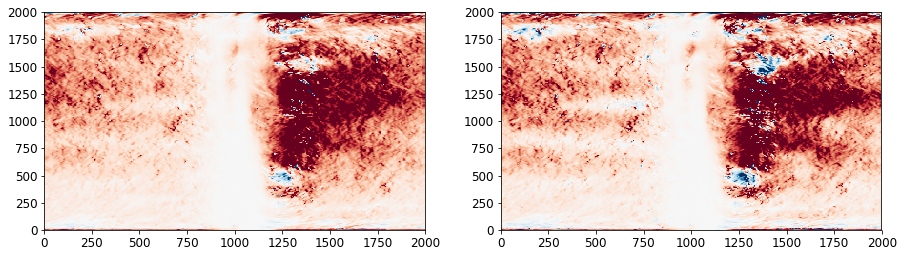

In [57]:
fig, ax = plt.subplots(1,2,figsize=(15,4))

im = ax[0].pcolormesh(X/1e3, Y/1e3, 
                 Ktensor_fast.isel(i=0,j=0).sel(Z=-1000, method='nearest') ,
                vmin=-9000, vmax=9000, cmap='RdBu_r')

im = ax[1].pcolormesh(X/1e3, Y/1e3, 
                 Ktensor_slow.isel(i=0,j=0).sel(Z=-1000, method='nearest') ,
                vmin=-9000, vmax=9000, cmap='RdBu_r')


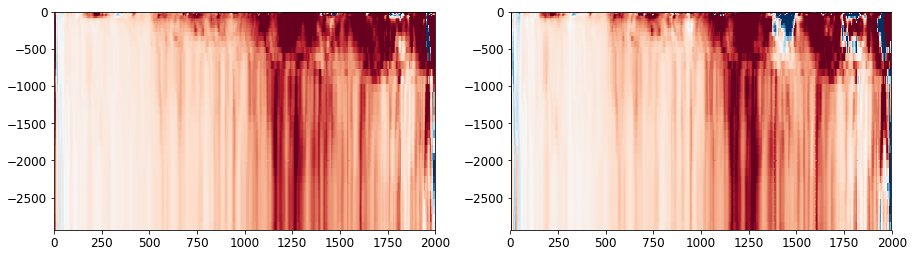

In [60]:
fig, ax = plt.subplots(1,2,figsize=(15,4))

im = ax[0].pcolormesh(Y/1e3, Z, 
                 Ktensor_fast.isel(i=0,j=0).sel(XC=0, method='nearest') ,
                vmin=-9000, vmax=9000, cmap='RdBu_r')

im = ax[1].pcolormesh(Y/1e3, Z, 
                 Ktensor_slow.isel(i=0,j=0).sel(XC=0, method='nearest') ,
                vmin=-9000, vmax=9000, cmap='RdBu_r')

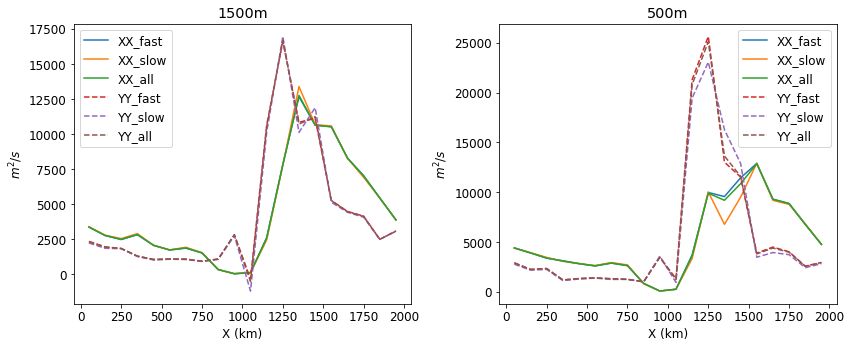

In [50]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(Xcoarse/1e3, Ktensor_fast.isel(i=0,j=0).sel(Z=-1500, method='nearest').sel(YCicoarse=10) 
         , label='XX_fast')
plt.plot(Xcoarse/1e3, Ktensor_slow.isel(i=0,j=0).sel(Z=-1500, method='nearest').sel(YCicoarse=10) 
         , label='XX_slow')
plt.plot(Xcoarse/1e3, Ktensor_all.isel(i=0,j=0).sel(Z=-1500, method='nearest').sel(YCicoarse=10) 
         , label='XX_all')

plt.plot(Xcoarse/1e3, Ktensor_fast.isel(i=1,j=1).sel(Z=-1500, method='nearest').sel(YCicoarse=10) 
         ,'--',  label='YY_fast')
plt.plot(Xcoarse/1e3, Ktensor_slow.isel(i=1,j=1).sel(Z=-1500, method='nearest').sel(YCicoarse=10) 
         ,'--', label='YY_slow')
plt.plot(Xcoarse/1e3, Ktensor_all.isel(i=1,j=1).sel(Z=-1500, method='nearest').sel(YCicoarse=10) 
         ,'--', label='YY_all')
plt.legend()
plt.title('1500m')
plt.xlabel('X (km)')
plt.ylabel('$m^2/s$')

plt.subplot(122)
plt.plot(Xcoarse/1e3, Ktensor_fast.isel(i=0,j=0).sel(Z=-500, method='nearest').sel(YCicoarse=10) 
         , label='XX_fast')
plt.plot(Xcoarse/1e3, Ktensor_slow.isel(i=0,j=0).sel(Z=-500, method='nearest').sel(YCicoarse=10) 
         , label='XX_slow')
plt.plot(Xcoarse/1e3, Ktensor_all.isel(i=0,j=0).sel(Z=-500, method='nearest').sel(YCicoarse=10) 
         , label='XX_all')

plt.plot(Xcoarse/1e3, Ktensor_fast.isel(i=1,j=1).sel(Z=-500, method='nearest').sel(YCicoarse=10) 
         ,'--',  label='YY_fast')
plt.plot(Xcoarse/1e3, Ktensor_slow.isel(i=1,j=1).sel(Z=-500, method='nearest').sel(YCicoarse=10) 
         ,'--', label='YY_slow')
plt.plot(Xcoarse/1e3, Ktensor_all.isel(i=1,j=1).sel(Z=-500, method='nearest').sel(YCicoarse=10) 
         ,'--', label='YY_all')
plt.legend()
plt.title('500m')
plt.xlabel('X (km)')
plt.ylabel('$m^2/s$')
plt.tight_layout()

# Errors in resproducing tracer fluxes 

In [61]:
recUflux_fast = Ktensor_fast.sel(i=0, j=0)*dCdx + Ktensor_fast.sel(i=0, j=1)*dCdy + \
            Ktensor_fast.sel(i=0, j=2)*dCdz
recVflux_fast = Ktensor_fast.sel(i=1, j=0)*dCdx + Ktensor_fast.sel(i=1, j=1)*dCdy + \
            Ktensor_fast.sel(i=1, j=2)*dCdz
recWflux_fast = Ktensor_fast.sel(i=2, j=0)*dCdx + Ktensor_fast.sel(i=2, j=1)*dCdy +  \
            Ktensor_fast.sel(i=2, j=2)*dCdz
    
errU_fast = np.abs(UpCp + recUflux_fast)/np.abs(UpCp)
errV_fast = np.abs(VpCp + recVflux_fast)/np.abs(VpCp)
errW_fast = np.abs(WpCp + recWflux_fast)/np.abs(WpCp)    

In [62]:
recUflux_slow = Ktensor_slow.sel(i=0, j=0)*dCdx + Ktensor_slow.sel(i=0, j=1)*dCdy + \
            Ktensor_slow.sel(i=0, j=2)*dCdz
recVflux_slow = Ktensor_slow.sel(i=1, j=0)*dCdx + Ktensor_slow.sel(i=1, j=1)*dCdy + \
            Ktensor_slow.sel(i=1, j=2)*dCdz
recWflux_slow = Ktensor_slow.sel(i=2, j=0)*dCdx + Ktensor_slow.sel(i=2, j=1)*dCdy +  \
            Ktensor_slow.sel(i=2, j=2)*dCdz
    
errU_slow = np.abs(UpCp + recUflux_slow)/np.abs(UpCp)
errV_slow = np.abs(VpCp + recVflux_slow)/np.abs(VpCp)
errW_slow = np.abs(WpCp + recWflux_slow)/np.abs(WpCp)    

In [53]:
recUflux_all = Ktensor_all.sel(i=0, j=0)*dCdx + Ktensor_all.sel(i=0, j=1)*dCdy + \
            Ktensor_all.sel(i=0, j=2)*dCdz
recVflux_all = Ktensor_all.sel(i=1, j=0)*dCdx + Ktensor_all.sel(i=1, j=1)*dCdy + \
            Ktensor_all.sel(i=1, j=2)*dCdz
recWflux_all = Ktensor_all.sel(i=2, j=0)*dCdx + Ktensor_all.sel(i=2, j=1)*dCdy +  \
            Ktensor_all.sel(i=2, j=2)*dCdz
    
errU_all = np.abs(UpCp + recUflux_all)/np.abs(UpCp)
errV_all = np.abs(VpCp + recVflux_all)/np.abs(VpCp)
errW_all = np.abs(WpCp + recWflux_all)/np.abs(WpCp)  

Text(0.5, 1.0, 'Err Fast - WC')

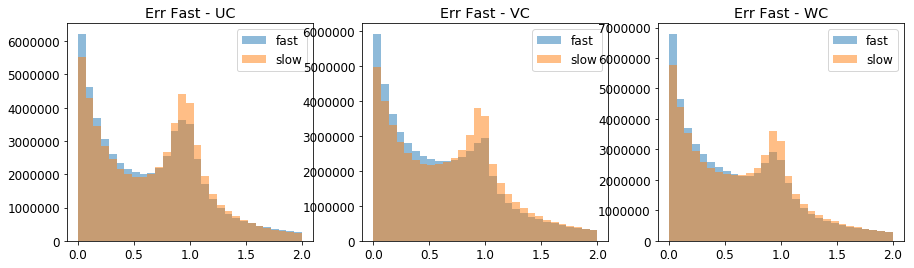

In [63]:
bins = np.linspace(0,2,30)

plt.figure(figsize=(15,4))

plt.subplot(131)
[_,_,_] = errU_fast.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errU_fast.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err Fast - UC')

plt.subplot(132)
[_,_,_] = errV_fast.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errV_fast.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err Fast - VC')

plt.subplot(133)
[_,_,_] = errW_fast.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errW_fast.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err Fast - WC')

Text(0.5, 1.0, 'Err Fast - WC')

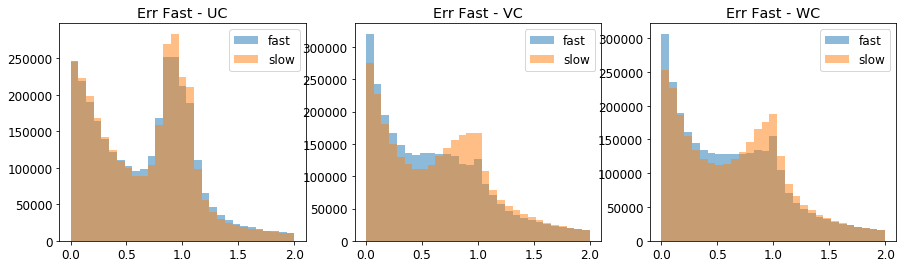

In [65]:
bins = np.linspace(0,2,30)

plt.figure(figsize=(15,4))

plt.subplot(131)
[_,_,_] = errU_fast.sel(XC=slice(0,800e3),YC=slice(600e3,1400e3),Z=slice(-600,-2000)).sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errU_fast.sel(XC=slice(0,800e3),YC=slice(600e3,1400e3),Z=slice(-600,-2000)).sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err Fast - UC')

plt.subplot(132)
[_,_,_] = errV_fast.sel(XC=slice(0,800e3),YC=slice(600e3,1400e3),Z=slice(-600,-2000)).sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errV_fast.sel(XC=slice(0,800e3),YC=slice(600e3,1400e3),Z=slice(-600,-2000)).sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err Fast - VC')

plt.subplot(133)
[_,_,_] = errW_fast.sel(XC=slice(0,800e3),YC=slice(600e3,1400e3),Z=slice(-600,-2000)).sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errW_fast.sel(XC=slice(0,800e3),YC=slice(600e3,1400e3),Z=slice(-600,-2000)).sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err Fast - WC')

Text(0.5, 1.0, 'Err slow - WC')

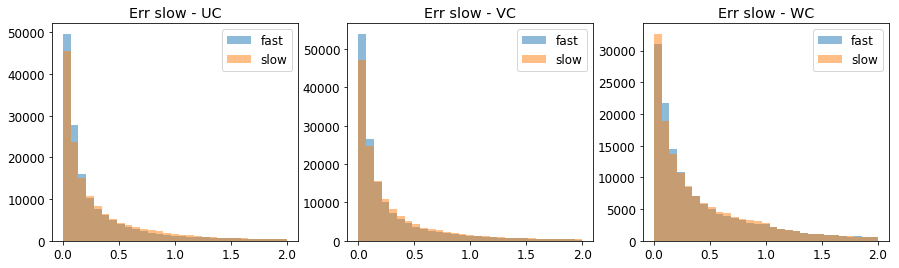

In [55]:
bins = np.linspace(0,2,30)

plt.figure(figsize=(15,4))

plt.subplot(131)
[_,_,_] = errU_slow.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errU_slow.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err slow - UC')

plt.subplot(132)
[_,_,_] = errV_slow.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errV_slow.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err slow - VC')

plt.subplot(133)
[_,_,_] = errW_slow.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errW_slow.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err slow - WC')

Text(0.5, 1.0, 'Err all - WC')

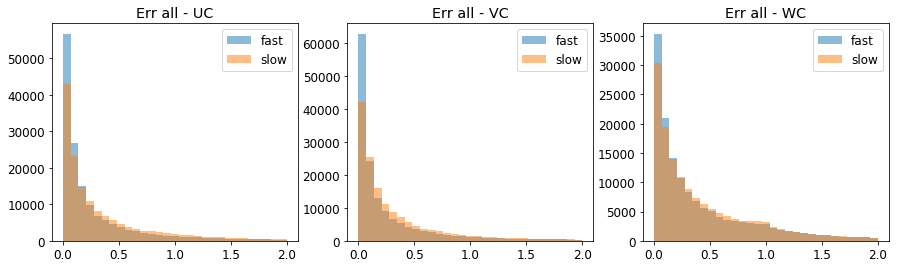

In [56]:
bins = np.linspace(0,2,30)

plt.figure(figsize=(15,4))

plt.subplot(131)
[_,_,_] = errU_all.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errU_all.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err all - UC')

plt.subplot(132)
[_,_,_] = errV_all.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errV_all.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err all - VC')

plt.subplot(133)
[_,_,_] = errW_all.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errW_all.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err all - WC')

Can do basic metrics etc...
It is interesting to see that the eddy diffusivity estimated using the slow tracers only, works marginally better for the fast tracers. hmm? 

# Errors in reproducing buoyancy fluxes

In [57]:
Tmean = Model_Tav.Ttave
Tmean.coords['YCicoarse'] = ('YC', YCicoarse)
Tmean.coords['XCicoarse'] = ('XC', XCicoarse)
T_coarse = xr.Dataset()
T_coarse['T'] = Tmean.groupby('YCicoarse').mean('YC')
T_coarse['T'] = T_coarse['T'].groupby('XCicoarse').mean('XC')
T_coarse.coords['Ycoarse'] = ('YCicoarse', Tmean.YC.groupby('YCicoarse').mean('YC'))
T_coarse.coords['Xcoarse'] = ('XCicoarse', Tmean.XC.groupby('XCicoarse').mean('XC'))

In [58]:
# Z grads
T_coarse['T_Z'] = -grid.diff(grid.interp(T_coarse['T'], 'Z', boundary='extend'),
                                    'Z', boundary='extend')/Tmean.drF

In [59]:
Tstag = Tmean
Tstag.coords['YSicoarse'] = ('YC', YSicoarse)
Tstag.coords['XSicoarse'] = ('XC', XSicoarse)

In [60]:
# Y grads 
Tstag_sav = Tstag.groupby('YSicoarse').mean('YC')
Tstag_sav = Tstag_sav.groupby('XCicoarse').mean('XC')

temp = Tstag_sav.diff('YSicoarse')/Lcoarse
temp[:,0,:] = temp[:,0,:] * 4/3
temp[:,-1,:] = temp[:,-1,:] * 4/3   
    
temp = xr.DataArray(temp.data, dims=['Z', 'YCicoarse', 'XCicoarse'],
                    coords=[ T_coarse.Z, T_coarse.YCicoarse,T_coarse.XCicoarse])
    
T_coarse['T_Y'] = temp

In [61]:
# X grads 
# only averate in X direction on center points
Tstag_sav = Tstag.groupby('YCicoarse').mean('YC')
Tstag_sav = Tstag_sav.groupby('XSicoarse').mean('XC')


temp = (Tstag_sav.data - np.roll(Tstag_sav.data,1,axis=2))/Lcoarse
temp = xr.DataArray(temp.data, dims=['Z', 'YCicoarse', 'XCicoarse'],
                    coords=[T_coarse.Z ,T_coarse.YCicoarse, T_coarse.XCicoarse])
        
T_coarse['T_X'] = temp

In [62]:
Model_Tav['UTtave'] = grid.interp(Model_Tav.UTtave, 'X')
Model_Tav['VTtave'] = grid.interp(Model_Tav.VTtave, 'Y', boundary='extend')
Model_Tav['WTtave'] = grid.interp(Model_Tav.WTtave, 'Z', boundary='extend')

In [63]:
Model_Tav.coords['YCicoarse'] = ('YC', YCicoarse)
Model_Tav.coords['XCicoarse'] = ('XC', XCicoarse)

T_coarse['UT'] = (Model_Tav['UTtave'].groupby('YCicoarse').mean('YC')).groupby('XCicoarse').mean('XC')
T_coarse['VT'] = (Model_Tav['VTtave'].groupby('YCicoarse').mean('YC')).groupby('XCicoarse').mean('XC')
T_coarse['WT'] = (Model_Tav['WTtave'].groupby('YCicoarse').mean('YC')).groupby('XCicoarse').mean('XC')

In [64]:
T_coarse['UpTp'] = T_coarse['UT'] - Vels_coarse['U'] *T_coarse['T']
T_coarse['VpTp'] = T_coarse['VT'] - Vels_coarse['V'] *T_coarse['T']
T_coarse['WpTp'] = T_coarse['WT'] - Vels_coarse['W'] *T_coarse['T']

In [65]:
# Recreated B fluxes fast

recUB_fast = Ktensor_fast.sel(i=0, j=0)*T_coarse.T_X + \
             Ktensor_fast.sel(i=0, j=1)*T_coarse.T_Y + \
             Ktensor_fast.sel(i=0, j=2)*T_coarse.T_Z
recVB_fast = Ktensor_fast.sel(i=1, j=0)*T_coarse.T_X + \
             Ktensor_fast.sel(i=1, j=1)*T_coarse.T_Y + \
             Ktensor_fast.sel(i=1, j=2)*T_coarse.T_Z
recWB_fast = Ktensor_fast.sel(i=2, j=0)*T_coarse.T_X + \
             Ktensor_fast.sel(i=2, j=1)*T_coarse.T_Y + \
             Ktensor_fast.sel(i=2, j=2)*T_coarse.T_Z

errUB_fast = np.abs(T_coarse.UpTp + recUB_fast)/np.abs(T_coarse.UpTp)
errVB_fast = np.abs(T_coarse.VpTp + recVB_fast)/np.abs(T_coarse.VpTp)
errWB_fast = np.abs(T_coarse.WpTp + recWB_fast)/np.abs(T_coarse.WpTp)

In [66]:
# Recreated B fluxes slow

recUB_slow = Ktensor_slow.sel(i=0, j=0)*T_coarse.T_X + \
             Ktensor_slow.sel(i=0, j=1)*T_coarse.T_Y + \
             Ktensor_slow.sel(i=0, j=2)*T_coarse.T_Z
recVB_slow = Ktensor_slow.sel(i=1, j=0)*T_coarse.T_X + \
             Ktensor_slow.sel(i=1, j=1)*T_coarse.T_Y + \
             Ktensor_slow.sel(i=1, j=2)*T_coarse.T_Z
recWB_slow = Ktensor_slow.sel(i=2, j=0)*T_coarse.T_X + \
             Ktensor_slow.sel(i=2, j=1)*T_coarse.T_Y + \
             Ktensor_slow.sel(i=2, j=2)*T_coarse.T_Z

errUB_slow = np.abs(T_coarse.UpTp + recUB_slow)/np.abs(T_coarse.UpTp)
errVB_slow = np.abs(T_coarse.VpTp + recVB_slow)/np.abs(T_coarse.VpTp)
errWB_slow = np.abs(T_coarse.WpTp + recWB_slow)/np.abs(T_coarse.WpTp)

In [67]:
# Recreated B fluxes all

recUB_all = Ktensor_all.sel(i=0, j=0)*T_coarse.T_X + \
             Ktensor_all.sel(i=0, j=1)*T_coarse.T_Y + \
             Ktensor_all.sel(i=0, j=2)*T_coarse.T_Z
recVB_all = Ktensor_all.sel(i=1, j=0)*T_coarse.T_X + \
             Ktensor_all.sel(i=1, j=1)*T_coarse.T_Y + \
             Ktensor_all.sel(i=1, j=2)*T_coarse.T_Z
recWB_all = Ktensor_all.sel(i=2, j=0)*T_coarse.T_X + \
             Ktensor_all.sel(i=2, j=1)*T_coarse.T_Y + \
             Ktensor_all.sel(i=2, j=2)*T_coarse.T_Z

errUB_all = np.abs(T_coarse.UpTp + recUB_all)/np.abs(T_coarse.UpTp)
errVB_all = np.abs(T_coarse.VpTp + recVB_all)/np.abs(T_coarse.VpTp)
errWB_all = np.abs(T_coarse.WpTp + recWB_all)/np.abs(T_coarse.WpTp)

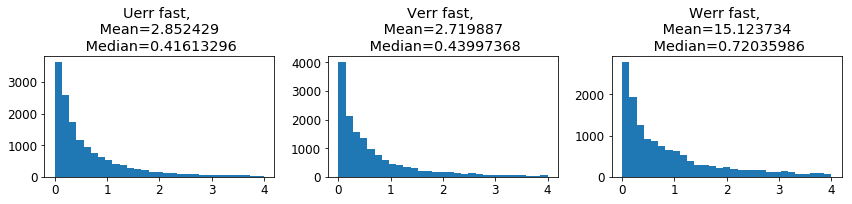

In [68]:
#  all the errors
bins = np.linspace(0,4,30)
plt.figure(figsize=(12,3))

plt.subplot(131)
[_,_,_] =errUB_fast.plot.hist(bins=bins)
m1 = errUB_fast.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errUB_fast.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Uerr fast, \n Mean=' + str(m1)+ ' \n Median='+str(m2))

plt.subplot(132)
[_,_,_] =errVB_fast.plot.hist(bins=bins)
m1 = errVB_fast.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errVB_fast.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Verr fast, \n Mean=' + str(m1)+ ' \n Median='+str(m2))

plt.subplot(133)
[_,_,_] =errWB_fast.plot.hist(bins=bins)
m1 = errWB_fast.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errWB_fast.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Werr fast, \n Mean=' + str(m1)+ ' \n Median='+str(m2))
plt.tight_layout()

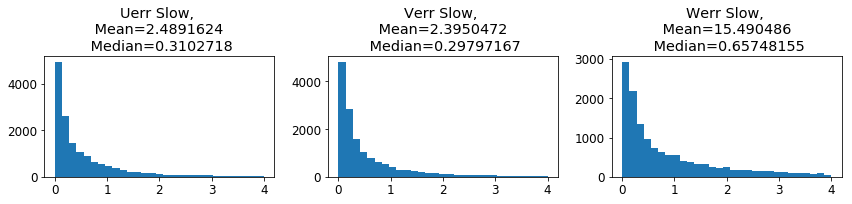

In [69]:
#  all the errors
bins = np.linspace(0,4,30)
plt.figure(figsize=(12,3))

plt.subplot(131)
[_,_,_] =errUB_slow.plot.hist(bins=bins)
m1 = errUB_slow.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errUB_slow.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Uerr Slow, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.subplot(132)
[_,_,_] =errVB_slow.plot.hist(bins=bins)
m1 = errVB_slow.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errVB_slow.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Verr Slow, \n Mean=' + str(m1)+ ' \n Median='+str(m2))

plt.subplot(133)
[_,_,_] =errWB_slow.plot.hist(bins=bins)
m1 = errWB_slow.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errWB_slow.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Werr Slow, \n Mean=' + str(m1)+ ' \n Median='+str(m2))
plt.tight_layout()

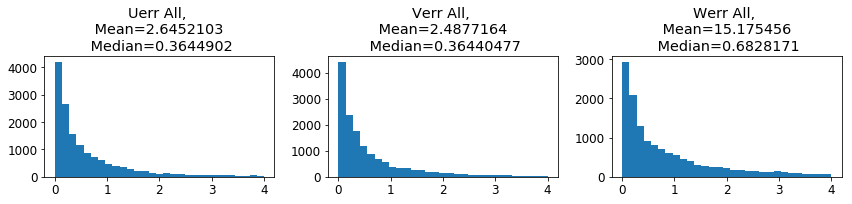

In [70]:
#  all the errors
bins = np.linspace(0,4,30)
plt.figure(figsize=(12,3))

plt.subplot(131)
[_,_,_] =errUB_all.plot.hist(bins=bins)
m1 = errUB_all.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errUB_all.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Uerr All, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.subplot(132)
[_,_,_] =errVB_all.plot.hist(bins=bins)
m1 = errVB_all.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errVB_all.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Verr All, \n Mean=' + str(m1)+ ' \n Median='+str(m2))

plt.subplot(133)
[_,_,_] =errWB_all.plot.hist(bins=bins)
m1 = errWB_all.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errWB_all.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Werr All, \n Mean=' + str(m1)+ ' \n Median='+str(m2))
plt.tight_layout()

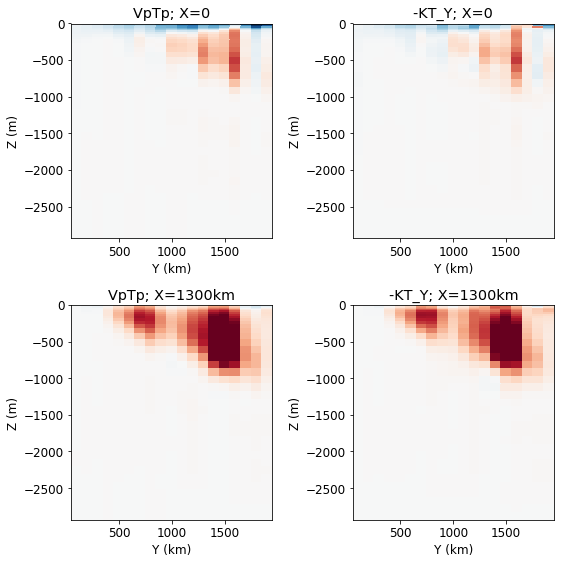

In [71]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0,0].pcolormesh(Ycoarse/1e3, Z, T_coarse.VpTp.sel(XCicoarse=0), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,0].set_title('VpTp; X=0')
ax[0,0].set_xlabel('Y (km)')
ax[0,0].set_ylabel('Z (m)')

ax[0,1].pcolormesh(Ycoarse/1e3, Z, -recVB_slow.sel(XCicoarse=0).T, vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,1].set_title('-KT_Y; X=0')
ax[0,1].set_xlabel('Y (km)')
ax[0,1].set_ylabel('Z (m)')

ax[1,0].pcolormesh(Ycoarse/1e3, Z, T_coarse.VpTp.sel(XCicoarse=13), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,0].set_title('VpTp; X=1300km')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

ax[1,1].pcolormesh(Ycoarse/1e3, Z, -recVB_slow.sel(XCicoarse=13).T, vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,1].set_title('-KT_Y; X=1300km')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')

plt.tight_layout()
plt.savefig('mer_flux_reconstruction_X.pdf')

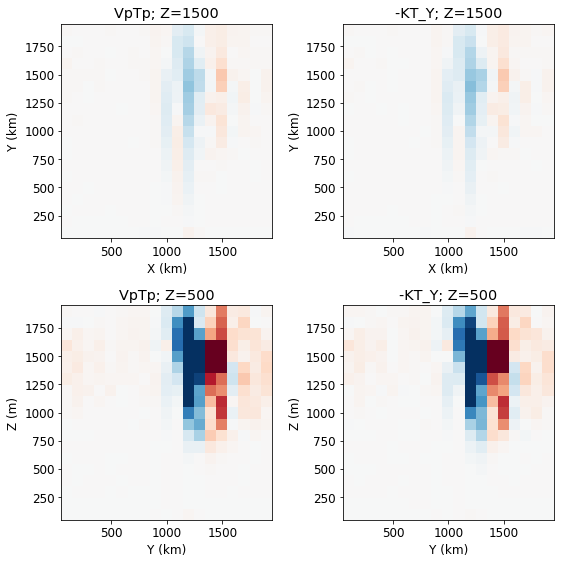

In [72]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-1500, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,0].set_title('VpTp; Z=1500')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Y (km)')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, -recVB_slow.sel(Z=-1500, method='nearest').T, vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,1].set_title('-KT_Y; Z=1500')
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Y (km)')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,0].set_title('VpTp; Z=500')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, -recVB_slow.sel(Z=-500, method='nearest').T, vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,1].set_title('-KT_Y; Z=500')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')

plt.tight_layout()
plt.savefig('mer_flux_reconstruction_Z.pdf')

# Use tracers with 2 times scales, assuming linearity to cancel the influence of restoring

Looking at equation 40 on in Bachman et al 2015 

$$ \overline{\mathbf{u}'c_1'} = - (\mathbf{K} + \lambda_1 \mathbf{D}) \nabla C_1 $$ 

$$ \overline{\mathbf{u}'c_2'} = - (\mathbf{K} + \lambda_2 \mathbf{D}) \nabla C_2 $$ 


The simple thing to do is eliminate $\mathbf{D}$. 

So 
$$ \overline{\mathbf{u}'c_1'} \nabla C_1 ^{-1} = - (\mathbf{K} + \lambda_1 \mathbf{D}) $$ 

$$ \overline{\mathbf{u}'c_2'} \nabla C_2 ^{-1} = - (\mathbf{K} + \lambda_2 \mathbf{D})  $$ 

So 

$$ \mathbf{K} = - \frac{\lambda_2 \overline{\mathbf{u}'c_1'} \nabla C_1 ^{-1} - \lambda_1\overline{\mathbf{u}'c_2'} \nabla C_2 ^{-1}}{ \lambda_2 - \lambda_1} $$

In [50]:
lam1 = 1/62208000.
lam2 = 1/186624000.

In [51]:
print(1/lam1/24/3600/360, 1/lam2/24/3600/360)

1.9999999999999998 6.0


In [76]:
Ktensor_corr = (lam2*Ktensor_fast - lam1*Ktensor_slow)/(lam2 - lam1)

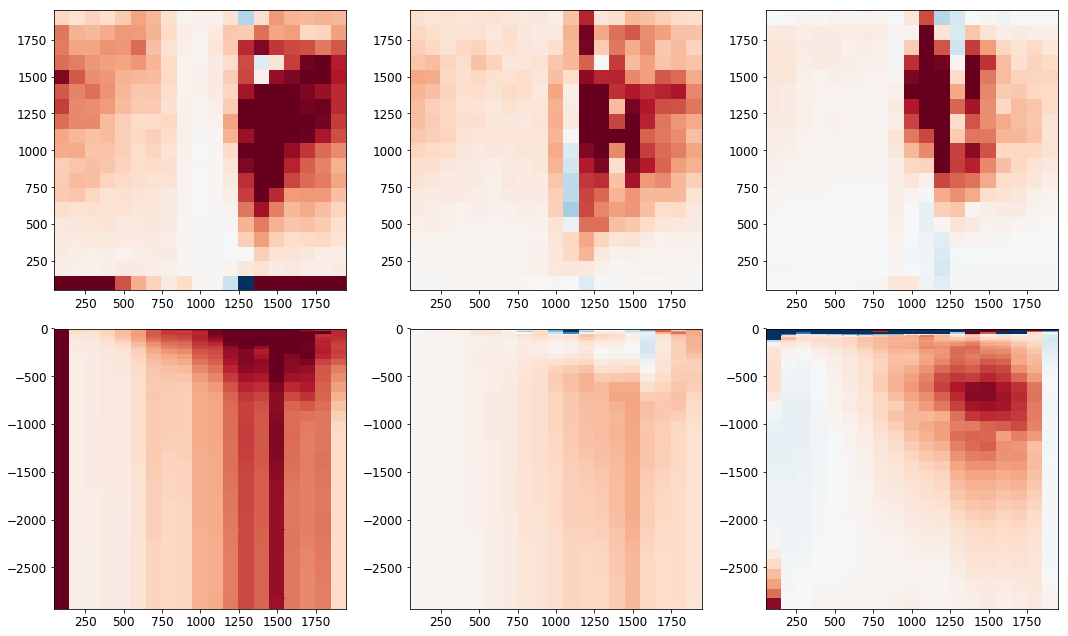

In [77]:
fig, ax = plt.subplots(2,3, figsize=(15,9))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Ktensor_corr.isel(i=0, j=0).sel(Z=-1000, method='nearest').T, 
               vmin=-9000, vmax=9000, cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Ktensor_corr.isel(i=1, j=1).sel(Z=-1000, method='nearest').T, 
               vmin=-9000, vmax=9000, cmap='RdBu_r')

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Ktensor_corr.isel(i=2, j=2).sel(Z=-1000, method='nearest').T, 
               vmin=-5e-3, vmax=5e-3, cmap='RdBu_r')

ax[1,0].pcolormesh(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=0).sel(XCicoarse=0, method='nearest').T, 
               vmin=-9000, vmax=9000, cmap='RdBu_r')

ax[1,1].pcolormesh(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).sel(XCicoarse=0, method='nearest').T, 
               vmin=-9000, vmax=9000, cmap='RdBu_r')

ax[1,2].pcolormesh(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=2).sel(XCicoarse=0, method='nearest').T, 
               vmin=-1e-3, vmax=1e-3, cmap='RdBu_r')

plt.tight_layout()

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'color'
  s)


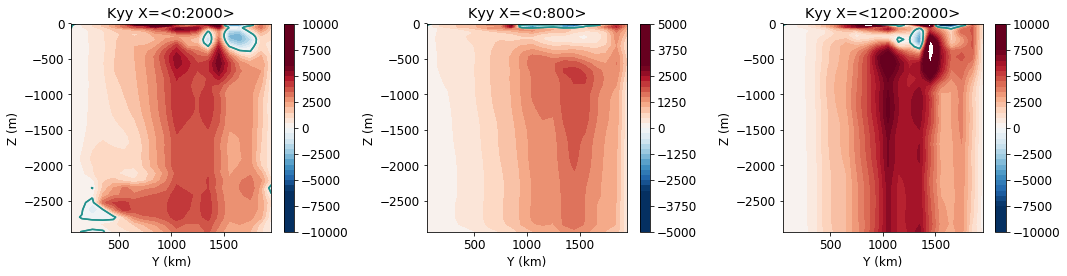

In [78]:
plt.figure(figsize=(15,4))

plt.subplot(131)
plt.contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).mean('XCicoarse').T, 
               vmin=-6000, vmax=6000, levels=np.linspace(-1e4, 1e4, 41), cmap='RdBu_r')

plt.colorbar()
plt.contour(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).mean('XCicoarse').T, 
               vmin=-6000, vmax=6000, levels=[-0.001, 0.001], color='k')

plt.title('Kyy X=<0:2000>')
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')

plt.subplot(132)
plt.contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-3000, vmax=3000, levels=np.linspace(-5e3, 5e3, 41), cmap='RdBu_r')
plt.colorbar()
plt.contour(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-6000, vmax=6000, levels=[-0.001, 0.001], color='k')
plt.title('Kyy X=<0:800>')
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')

plt.subplot(133)
plt.contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-7500, vmax=7500, levels=np.linspace(-1e4, 10e3, 41), cmap='RdBu_r')
plt.colorbar()
plt.contour(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-6000, vmax=6000, levels=[-0.001, 0.001], color='k')
plt.title('Kyy X=<1200:2000>')
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')

plt.tight_layout()
# maybe there is an indication of a mid depth max...??

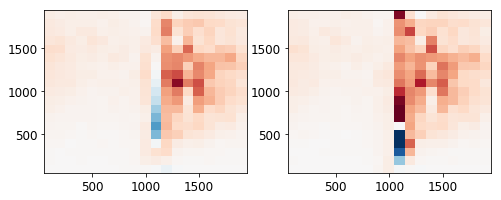

In [79]:
# Anything funny near ridge

plt.figure(figsize=(8,3))

plt.subplot(121)
plt.pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Ktensor_corr.sel(Z=-1500, method='nearest').isel(i=1, j=1).T, 
               vmin=-19000, vmax=19000, cmap='RdBu_r')

plt.subplot(122)
plt.pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Ktensor_corr.sel(Z=-2700, method='nearest').isel(i=1, j=1).T, 
               vmin=-19000, vmax=19000, cmap='RdBu_r')

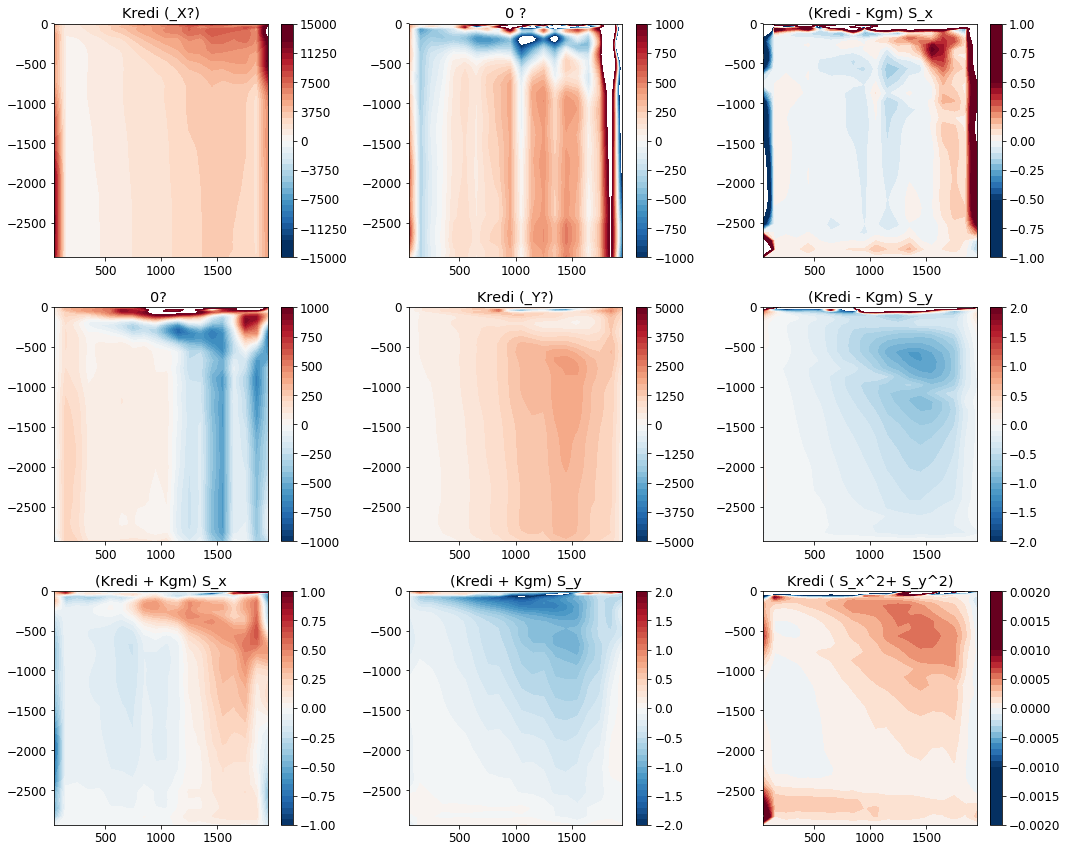

In [80]:
fig , ax = plt.subplots(3,3,figsize=(15,12))

im = ax[0,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-13000, vmax=13000, levels=np.linspace(-15e3, 15e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,0])
ax[0,0].set_title('Kredi (_X?)')

im = ax[0,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,1])
ax[0,1].set_title('0 ?')

im = ax[0,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,2])
ax[0,2].set_title('(Kredi - Kgm) S_x')

##
im = ax[1,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,0])
ax[1,0].set_title('0? ')

im = ax[1,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-5000, vmax=5000, levels=np.linspace(-5e3, 5e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,1])
ax[1,1].set_title('Kredi (_Y?)')


im = ax[1,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,2])
ax[1,2].set_title('(Kredi - Kgm) S_y')


##
im = ax[2,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1, vmax=1, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,0])
ax[2,0].set_title('(Kredi + Kgm) S_x')

im = ax[2,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,1])
ax[2,1].set_title('(Kredi + Kgm) S_y')

im = ax[2,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1e-3, vmax=1e-3, levels=np.linspace(-2e-3, 2e-3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,2])
ax[2,2].set_title('Kredi ( S_x^2+ S_y^2)')

plt.tight_layout()

## Using K tensor to recreate the fluxes

In [81]:
recUflux_corr = Ktensor_corr.sel(i=0, j=0)*dCdx + Ktensor_corr.sel(i=0, j=1)*dCdy + \
                Ktensor_corr.sel(i=0, j=2)*dCdz
recVflux_corr = Ktensor_corr.sel(i=1, j=0)*dCdx + Ktensor_corr.sel(i=1, j=1)*dCdy + \
                Ktensor_corr.sel(i=1, j=2)*dCdz
recWflux_corr = Ktensor_corr.sel(i=2, j=0)*dCdx + Ktensor_corr.sel(i=2, j=1)*dCdy +  \
                Ktensor_corr.sel(i=2, j=2)*dCdz
    
errU_corr = np.abs(UpCp + recUflux_corr)/np.abs(UpCp)
errV_corr = np.abs(VpCp + recVflux_corr)/np.abs(VpCp)
errW_corr = np.abs(WpCp + recWflux_corr)/np.abs(WpCp)   

Text(0.5, 1.0, 'Err Corr - WC')

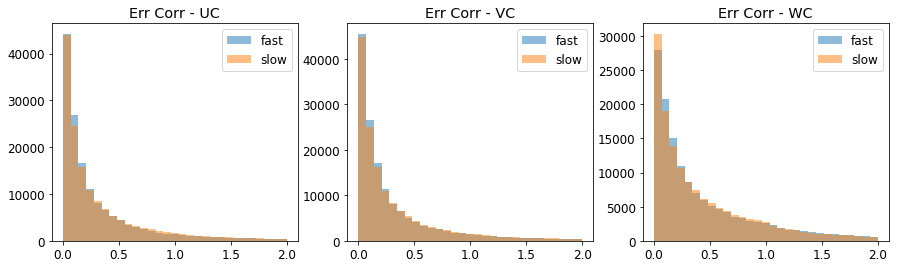

In [82]:
bins = np.linspace(0,2,30)

plt.figure(figsize=(15,4))

plt.subplot(131)
[_,_,_] = errU_corr.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errU_corr.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err Corr - UC')

plt.subplot(132)
[_,_,_] = errV_corr.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errV_corr.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err Corr - VC')

plt.subplot(133)
[_,_,_] = errW_corr.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errW_corr.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err Corr - WC')

In [ ]:
# Patterns of error 

In [123]:
errU_corr.tracer_num

<xarray.DataArray 'tracer_num' (tracer_num: 20)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20])
Coordinates:
  * tracer_num  (tracer_num) int64 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20

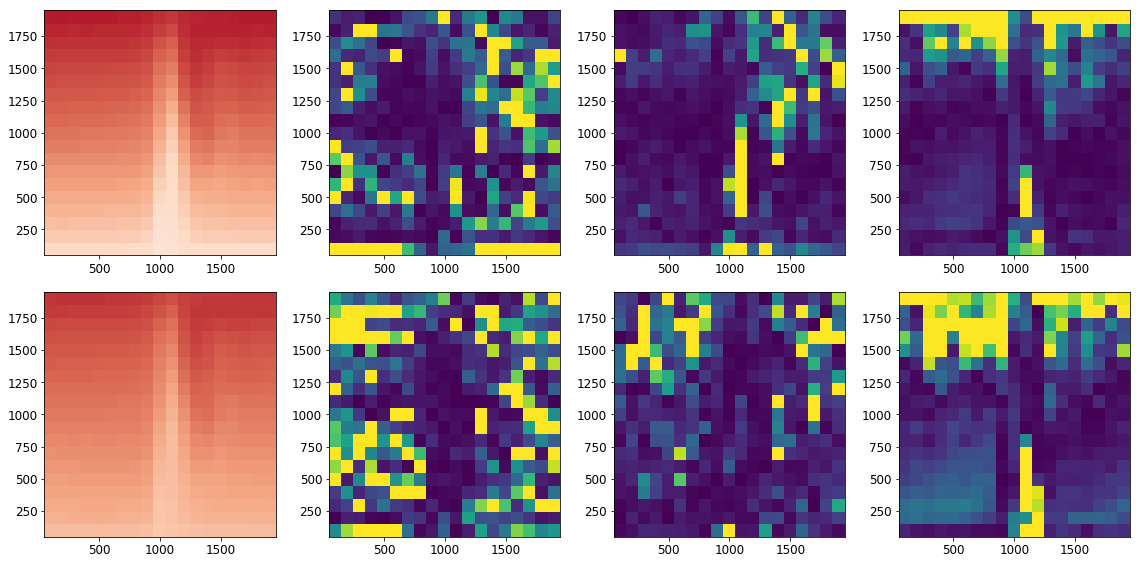

In [128]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'01'].sel(Z=-500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=1).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=1).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=1).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'02'].sel(Z=-500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=2).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=2).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=2).sel(Z=-500, method='nearest').T,
              vmax=1.)
plt.tight_layout()


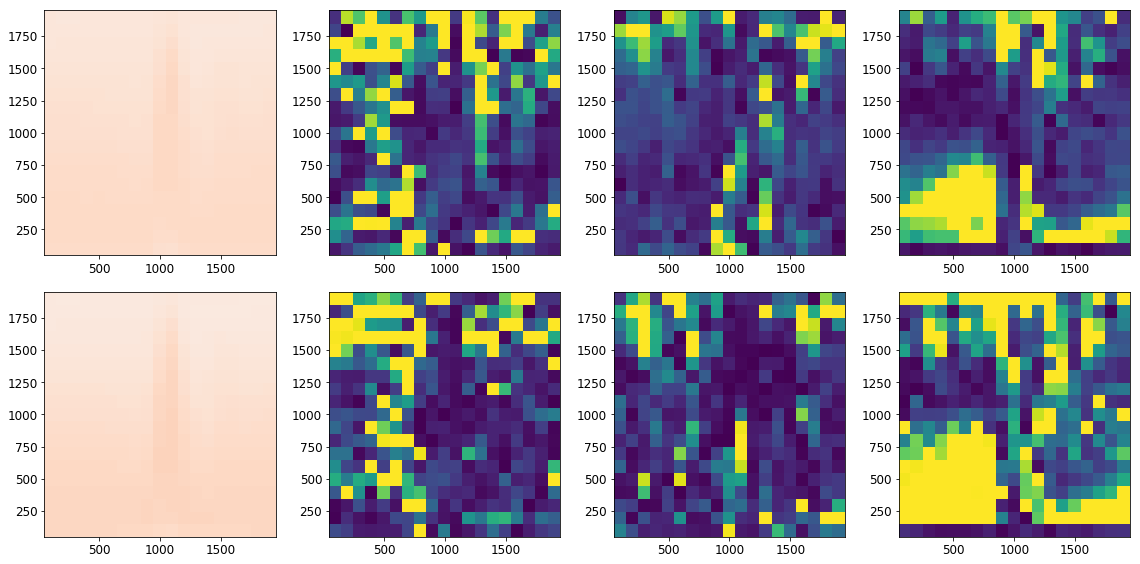

In [130]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))
n=3 
ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n)].sel(Z=-500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n+1)].sel(Z=-500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n+1).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n+1).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n+1).sel(Z=-500, method='nearest').T,
              vmax=1.)
plt.tight_layout()

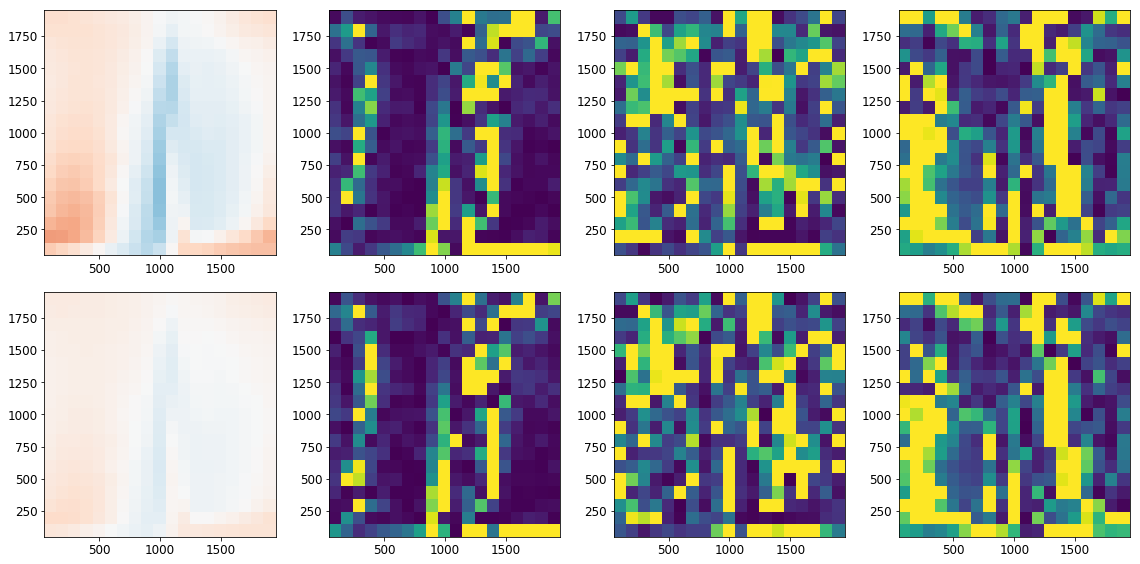

In [131]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))
n=5
ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n)].sel(Z=-500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n+1)].sel(Z=-500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n+1).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n+1).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n+1).sel(Z=-500, method='nearest').T,
              vmax=1.)
plt.tight_layout()

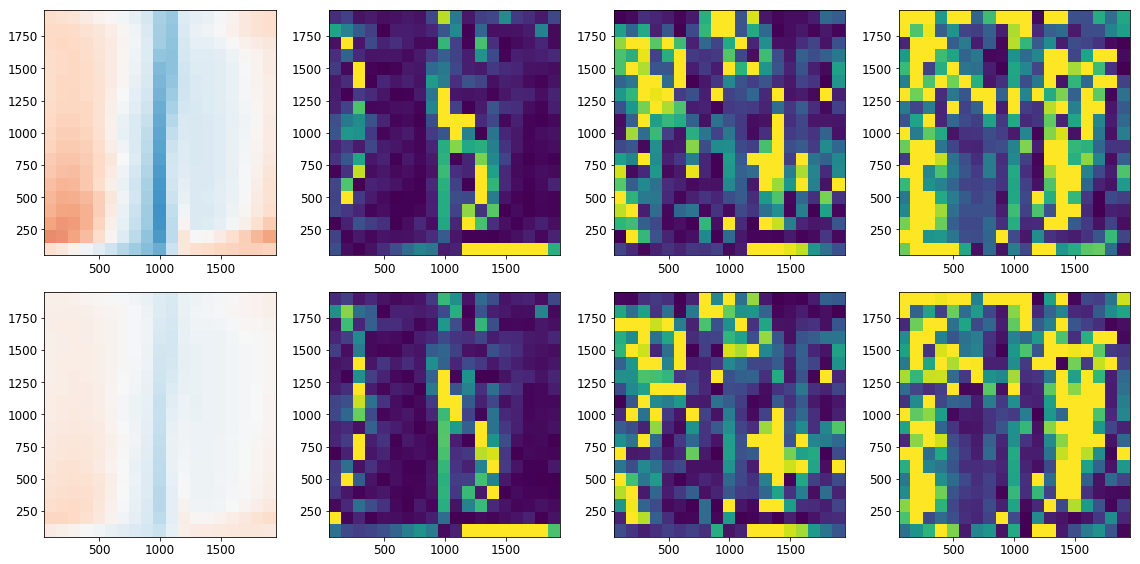

In [132]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))
n=5
ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n+1)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)
plt.tight_layout()

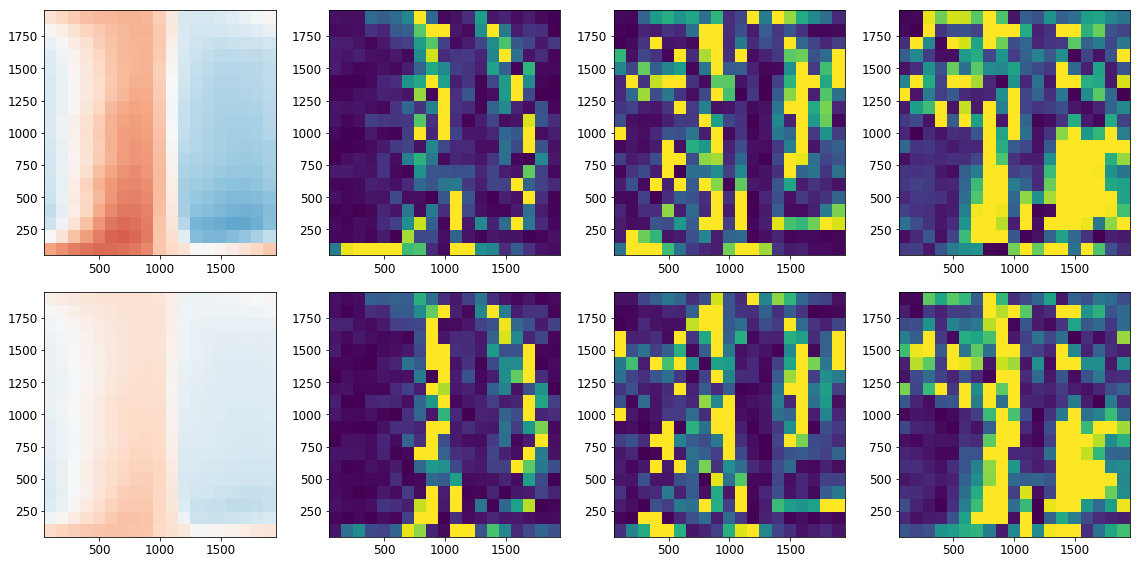

In [133]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))
n=7
ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n+1)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)
plt.tight_layout()

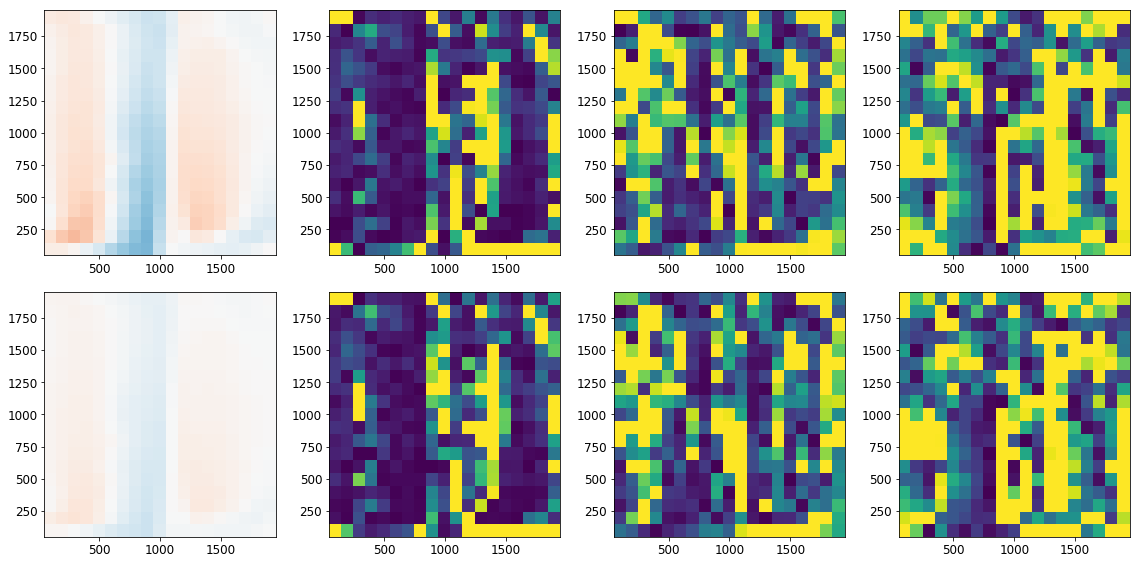

In [137]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))
n=9
ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+str(n+1)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)
plt.tight_layout()

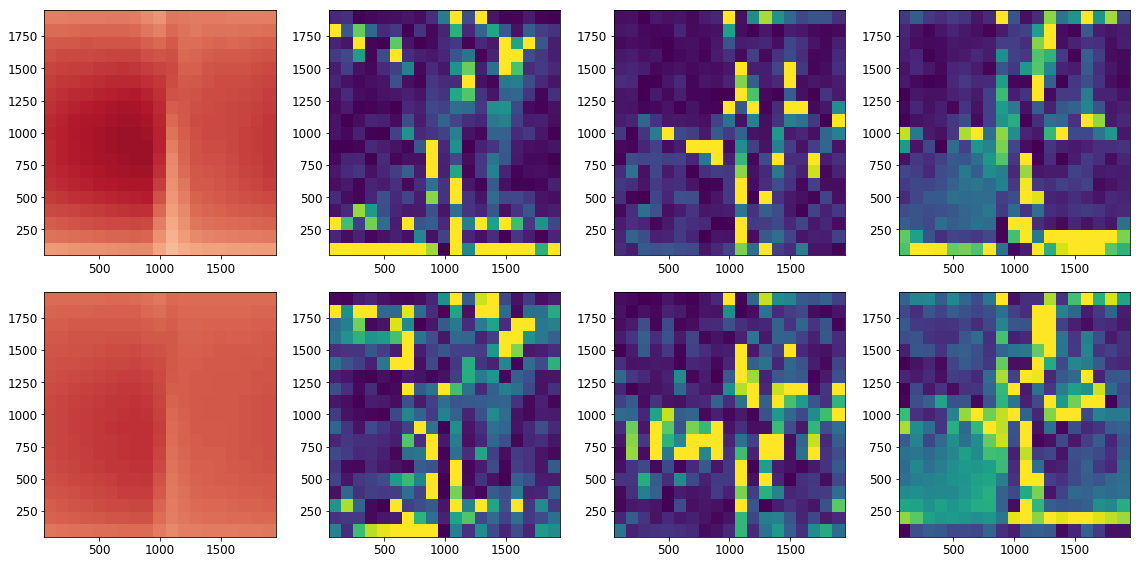

In [139]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))
n=11
ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+str(n)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+str(n+1)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)
plt.tight_layout()

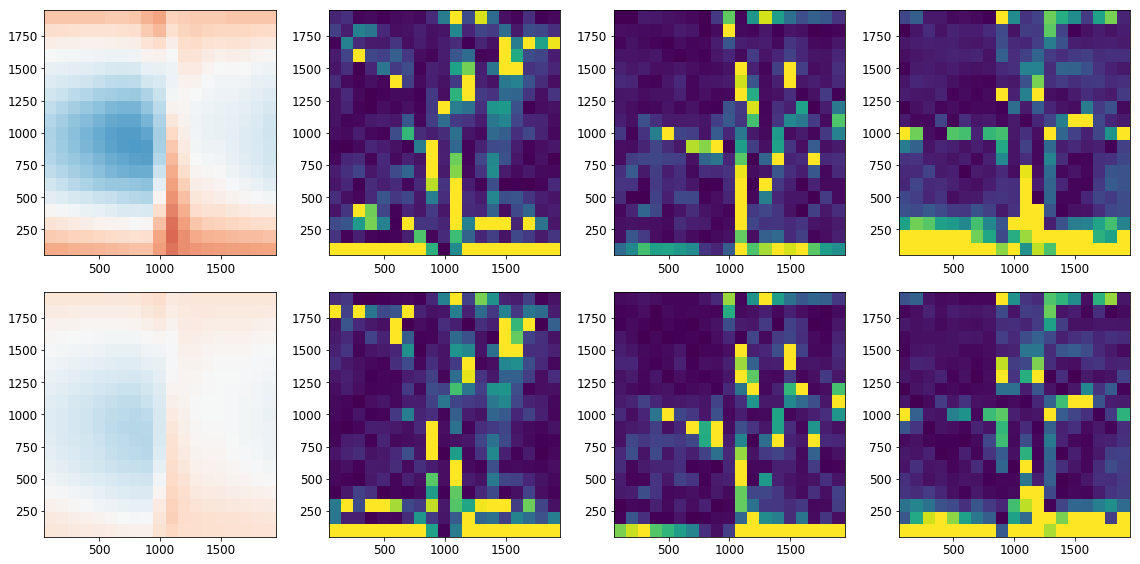

In [140]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))
n=13
ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+str(n)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+str(n+1)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)
plt.tight_layout()

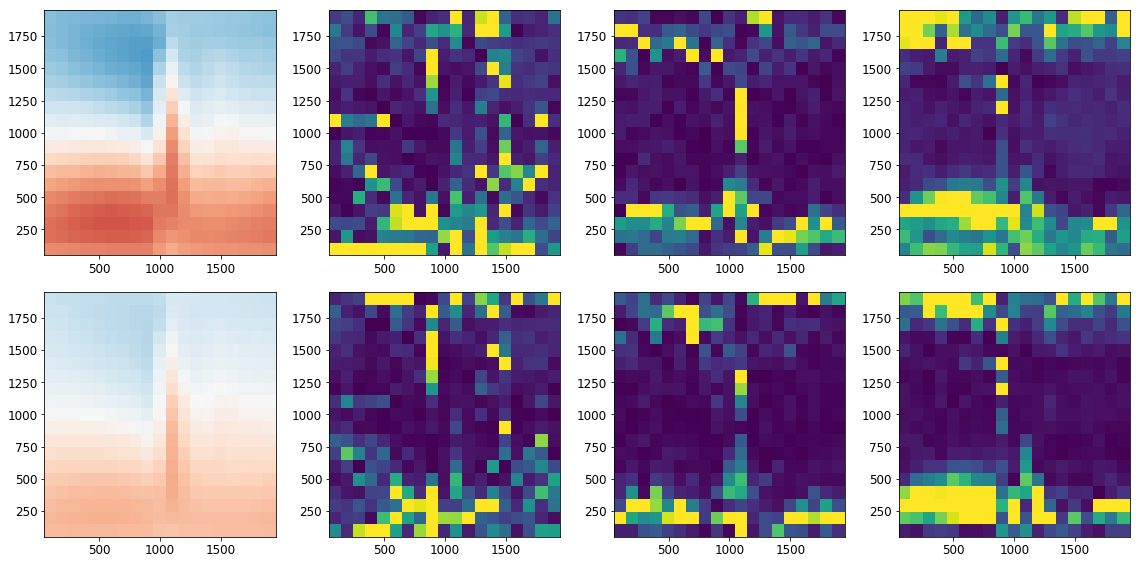

In [141]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))
n=15
ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+str(n)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+str(n+1)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)
plt.tight_layout()

### Recreated B fluxes

In [165]:
recUB_corr = Ktensor_corr.sel(i=0, j=0)*T_coarse.T_X + \
             Ktensor_corr.sel(i=0, j=1)*T_coarse.T_Y + \
             Ktensor_corr.sel(i=0, j=2)*T_coarse.T_Z
recVB_corr = Ktensor_corr.sel(i=1, j=0)*T_coarse.T_X + \
             Ktensor_corr.sel(i=1, j=1)*T_coarse.T_Y + \
             Ktensor_corr.sel(i=1, j=2)*T_coarse.T_Z
recWB_corr = Ktensor_corr.sel(i=2, j=0)*T_coarse.T_X + \
             Ktensor_corr.sel(i=2, j=1)*T_coarse.T_Y + \
             Ktensor_corr.sel(i=2, j=2)*T_coarse.T_Z

errUB_corr = np.abs(T_coarse.UpTp + recUB_corr)/np.abs(T_coarse.UpTp)
errVB_corr = np.abs(T_coarse.VpTp + recVB_corr)/np.abs(T_coarse.VpTp)
errWB_corr = np.abs(T_coarse.WpTp + recWB_corr)/np.abs(T_coarse.WpTp)

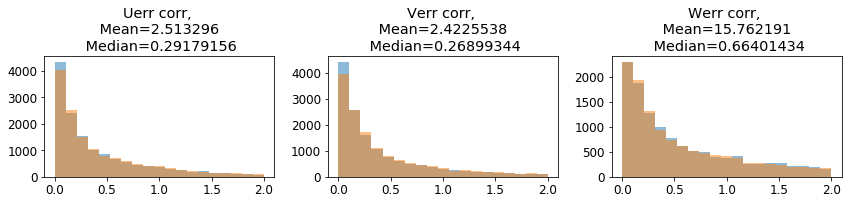

In [84]:
#  all the errors
bins = np.linspace(0,2,20)
plt.figure(figsize=(12,3))

plt.subplot(131)
[_,_,_] =errUB_corr.plot.hist(bins=bins, alpha=0.5)
[_,_,_] =errUB_slow.plot.hist(bins=bins, alpha=0.5)
m1 = errUB_corr.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errUB_corr.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Uerr corr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.subplot(132)
[_,_,_] =errVB_corr.plot.hist(bins=bins, alpha=0.5)
[_,_,_] =errVB_slow.plot.hist(bins=bins, alpha=0.5)
m1 = errVB_corr.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errVB_corr.median(['XCicoarse','YCicoarse','Z']).values
plt.title('Verr corr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))

plt.subplot(133)
[_,_,_] =errWB_corr.plot.hist(bins=bins, alpha=0.5)
[_,_,_] =errWB_slow.plot.hist(bins=bins, alpha=0.5)
m1 = errWB_corr.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errWB_corr.median(['XCicoarse','YCicoarse','Z']).values
plt.title('Werr corr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))
plt.tight_layout()

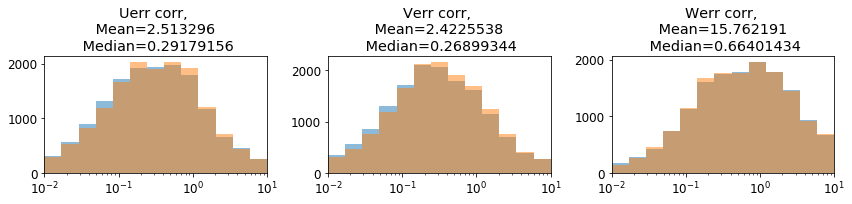

In [85]:
#  all the errors
bins = np.logspace(-2,1,14)
plt.figure(figsize=(12,3))

plt.subplot(131)
[_,_,_] =errUB_corr.plot.hist(bins=bins, alpha=0.5)
[_,_,_] =errUB_slow.plot.hist(bins=bins, alpha=0.5)
m1 = errUB_corr.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errUB_corr.median(['XCicoarse','YCicoarse','Z']).values
plt.xscale('log')
plt.xlim([0.01, 10])
plt.title('Uerr corr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.subplot(132)
[_,_,_] =errVB_corr.plot.hist(bins=bins, alpha=0.5)
[_,_,_] =errVB_slow.plot.hist(bins=bins, alpha=0.5)
m1 = errVB_corr.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errVB_corr.median(['XCicoarse','YCicoarse','Z']).values
plt.xscale('log')
plt.xlim([0.01, 10])
plt.title('Verr corr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))

plt.subplot(133)
[_,_,_] =errWB_corr.plot.hist(bins=bins, alpha=0.5)
[_,_,_] =errWB_slow.plot.hist(bins=bins, alpha=0.5)
m1 = errWB_corr.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errWB_corr.median(['XCicoarse','YCicoarse','Z']).values
plt.xscale('log')
plt.xlim([0.01, 10])
plt.title('Werr corr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))
plt.tight_layout()

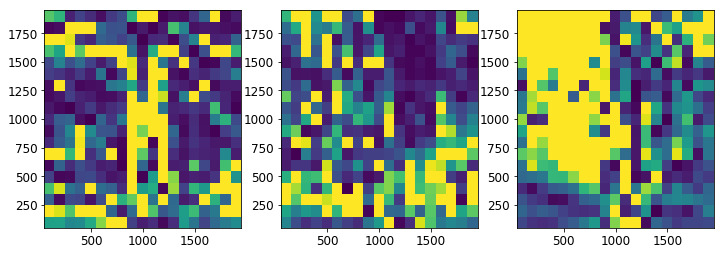

In [149]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errUB_corr.sel(Z=-500, method='nearest'),
              vmax=1.)

ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errVB_corr.sel(Z=-500, method='nearest'),
              vmax=1.)

ax[2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errWB_corr.sel(Z=-500, method='nearest'),
              vmax=1.)

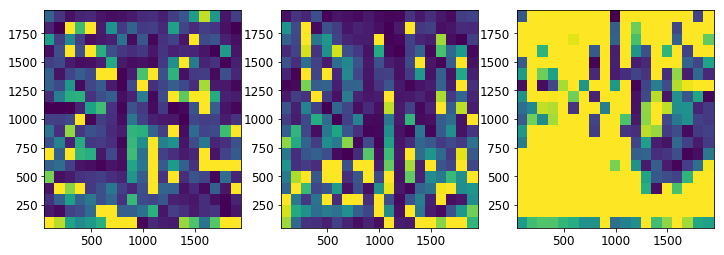

In [151]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errUB_corr.sel(Z=-1500, method='nearest'),
              vmax=1.)

ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errVB_corr.sel(Z=-1500, method='nearest'),
              vmax=1.)

ax[2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errWB_corr.sel(Z=-1500, method='nearest'),
              vmax=1.)

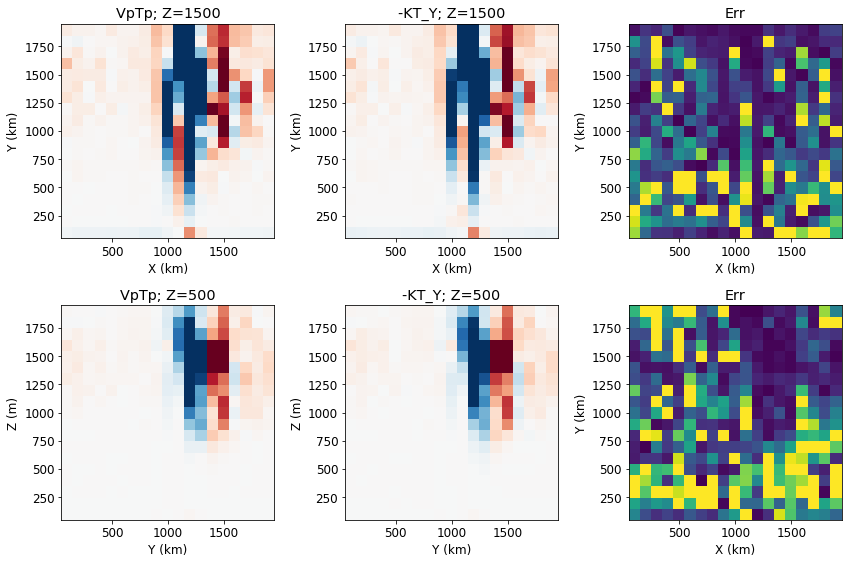

In [156]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-1500, method='nearest'), vmin=-0.001, vmax=0.001, cmap='RdBu_r')
ax[0,0].set_title('VpTp; Z=1500')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Y (km)')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, -recVB_corr.sel(Z=-1500, method='nearest').T, vmin=-0.001, vmax=0.001, cmap='RdBu_r')
ax[0,1].set_title('-KT_Y; Z=1500')
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Y (km)')

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errVB_corr.sel(Z=-1500, method='nearest'), vmin=0, vmax=1)
ax[0,2].set_title('Err')
ax[0,2].set_xlabel('X (km)')
ax[0,2].set_ylabel('Y (km)')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,0].set_title('VpTp; Z=500')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, -recVB_corr.sel(Z=-500, method='nearest').T, vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,1].set_title('-KT_Y; Z=500')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errVB_corr.sel(Z=-500, method='nearest'), vmin=0, vmax=1)
ax[1,2].set_title('Err')
ax[1,2].set_xlabel('X (km)')
ax[1,2].set_ylabel('Y (km)')

plt.tight_layout()

# It appears that errors are large when the fluxes are small. 

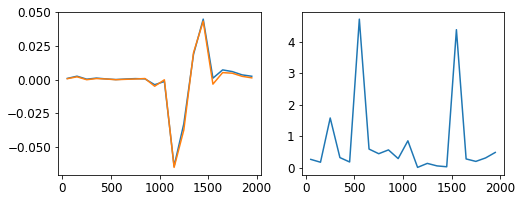

In [161]:
plt.figure(figsize=(8,3) )

plt.subplot(121)
plt.plot(Xcoarse/1e3, T_coarse.VpTp.sel(Z=-500, method='nearest').sel(YCicoarse=10))
plt.plot(Xcoarse/1e3, -recVB_corr.sel(Z=-500, method='nearest').sel(YCicoarse=10))

plt.subplot(122)
plt.plot(Xcoarse/1e3, errVB_corr.sel(Z=-500, method='nearest').sel(YCicoarse=10))


(-0.003, 0.003)

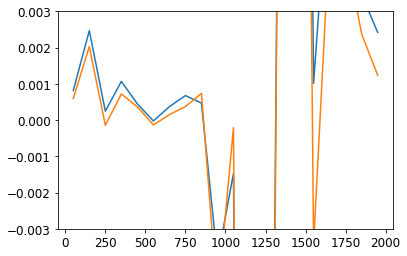

In [166]:
#plt.subplot(121)
plt.plot(Xcoarse/1e3, T_coarse.VpTp.sel(Z=-500, method='nearest').sel(YCicoarse=10))
plt.plot(Xcoarse/1e3, -recVB_corr.sel(Z=-500, method='nearest').sel(YCicoarse=10))
plt.ylim([-3e-3, 3e-3])

Marginal improvement when using corrected fluxes, in contrast to the slow fluxes.

We will just use the corrected tensor from now on. 

 ## Decompose into Symmetric and Antisymmetric Parts

In [86]:
Ktensor_corrT = Ktensor_corr.transpose('XCicoarse','YCicoarse','Z','j','i')

ST = 0.5*(Ktensor_corr.data + Ktensor_corrT.data)
AT = 0.5*(Ktensor_corr.data - Ktensor_corrT.data)

ST = xr.DataArray(ST, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)
AT = xr.DataArray(AT, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)

### S

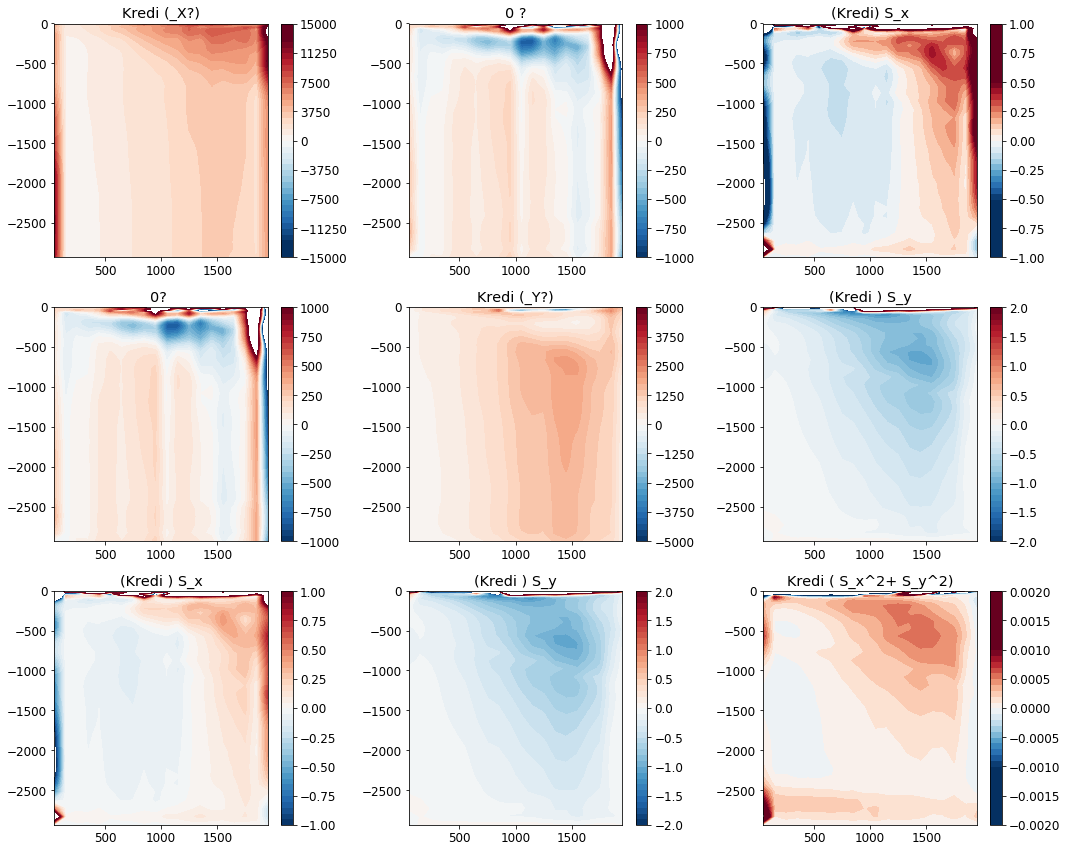

In [87]:
# 
fig , ax = plt.subplots(3,3,figsize=(15,12))

im = ax[0,0].contourf(Ycoarse/1e3, Z, ST.isel(i=0, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-13000, vmax=13000, levels=np.linspace(-15e3, 15e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,0])
ax[0,0].set_title('Kredi (_X?)')

im = ax[0,1].contourf(Ycoarse/1e3, Z, ST.isel(i=0, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,1])
ax[0,1].set_title('0 ?')

im = ax[0,2].contourf(Ycoarse/1e3, Z, ST.isel(i=0, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,2])
ax[0,2].set_title('(Kredi) S_x')

##
im = ax[1,0].contourf(Ycoarse/1e3, Z, ST.isel(i=1, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,0])
ax[1,0].set_title('0? ')

im = ax[1,1].contourf(Ycoarse/1e3, Z, ST.isel(i=1, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-5000, vmax=5000, levels=np.linspace(-5e3, 5e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,1])
ax[1,1].set_title('Kredi (_Y?)')


im = ax[1,2].contourf(Ycoarse/1e3, Z, ST.isel(i=1, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,2])
ax[1,2].set_title('(Kredi ) S_y')


##
im = ax[2,0].contourf(Ycoarse/1e3, Z, ST.isel(i=2, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1, vmax=1, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,0])
ax[2,0].set_title('(Kredi ) S_x')

im = ax[2,1].contourf(Ycoarse/1e3, Z, ST.isel(i=2, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,1])
ax[2,1].set_title('(Kredi ) S_y')

im = ax[2,2].contourf(Ycoarse/1e3, Z, ST.isel(i=2, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1e-3, vmax=1e-3, levels=np.linspace(-2e-3, 2e-3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,2])
ax[2,2].set_title('Kredi ( S_x^2+ S_y^2)')

plt.tight_layout()

### A

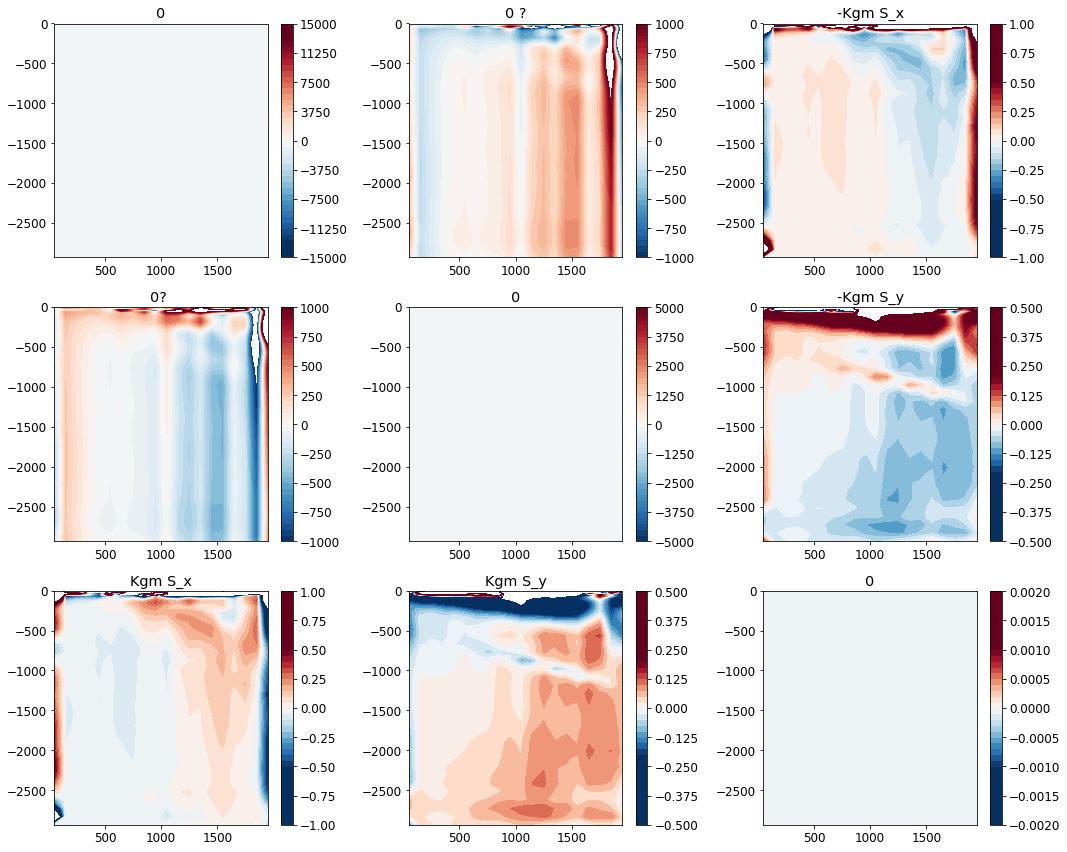

In [88]:
# 
fig , ax = plt.subplots(3,3,figsize=(15,12))

im = ax[0,0].contourf(Ycoarse/1e3, Z, AT.isel(i=0, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-13000, vmax=13000, levels=np.linspace(-15e3, 15e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,0])
ax[0,0].set_title('0')

im = ax[0,1].contourf(Ycoarse/1e3, Z, AT.isel(i=0, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,1])
ax[0,1].set_title('0 ?')

im = ax[0,2].contourf(Ycoarse/1e3, Z, AT.isel(i=0, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,2])
ax[0,2].set_title('-Kgm S_x')

##
im = ax[1,0].contourf(Ycoarse/1e3, Z, AT.isel(i=1, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,0])
ax[1,0].set_title('0? ')

im = ax[1,1].contourf(Ycoarse/1e3, Z, AT.isel(i=1, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-5000, vmax=5000, levels=np.linspace(-5e3, 5e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,1])
ax[1,1].set_title('0')


im = ax[1,2].contourf(Ycoarse/1e3, Z, AT.isel(i=1, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-0.2, vmax=0.2, levels=np.linspace(-0.5, 0.5, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,2])
ax[1,2].set_title('-Kgm S_y')


##
im = ax[2,0].contourf(Ycoarse/1e3, Z, AT.isel(i=2, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,0])
ax[2,0].set_title('Kgm S_x')

im = ax[2,1].contourf(Ycoarse/1e3, Z, AT.isel(i=2, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-0.2, vmax=0.2, levels=np.linspace(-0.5, 0.5, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,1])
ax[2,1].set_title('Kgm S_y')

im = ax[2,2].contourf(Ycoarse/1e3, Z, AT.isel(i=2, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1e-3, vmax=1e-3, levels=np.linspace(-2e-3, 2e-3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,2])
ax[2,2].set_title('0')

plt.tight_layout()

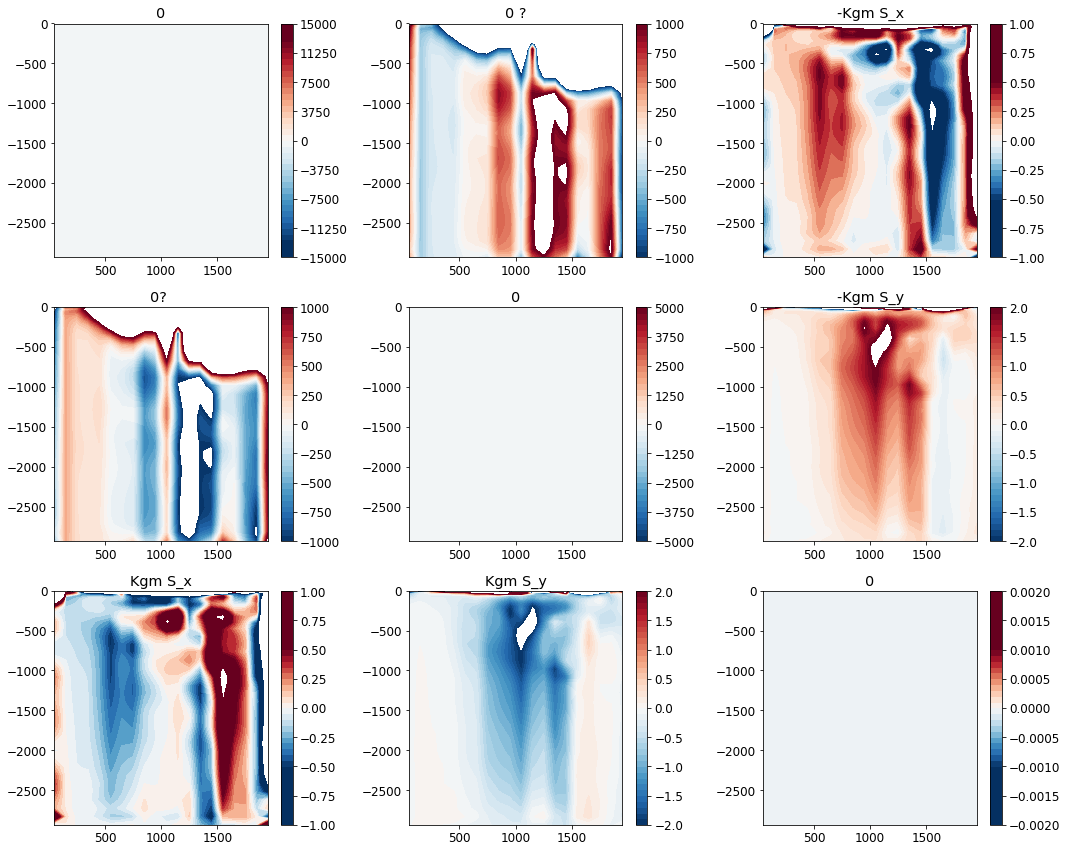

In [89]:
# 
fig , ax = plt.subplots(3,3,figsize=(15,12))

im = ax[0,0].contourf(Ycoarse/1e3, Z, AT.isel(i=0, j=0).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-13000, vmax=13000, levels=np.linspace(-15e3, 15e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,0])
ax[0,0].set_title('0')

im = ax[0,1].contourf(Ycoarse/1e3, Z, AT.isel(i=0, j=1).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,1])
ax[0,1].set_title('0 ?')

im = ax[0,2].contourf(Ycoarse/1e3, Z, AT.isel(i=0, j=2).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,2])
ax[0,2].set_title('-Kgm S_x')

##
im = ax[1,0].contourf(Ycoarse/1e3, Z, AT.isel(i=1, j=0).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,0])
ax[1,0].set_title('0? ')

im = ax[1,1].contourf(Ycoarse/1e3, Z, AT.isel(i=1, j=1).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-5000, vmax=5000, levels=np.linspace(-5e3, 5e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,1])
ax[1,1].set_title('0')


im = ax[1,2].contourf(Ycoarse/1e3, Z, AT.isel(i=1, j=2).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,2])
ax[1,2].set_title('-Kgm S_y')


##
im = ax[2,0].contourf(Ycoarse/1e3, Z, AT.isel(i=2, j=0).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,0])
ax[2,0].set_title('Kgm S_x')

im = ax[2,1].contourf(Ycoarse/1e3, Z, AT.isel(i=2, j=1).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,1])
ax[2,1].set_title('Kgm S_y')

im = ax[2,2].contourf(Ycoarse/1e3, Z, AT.isel(i=2, j=2).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-1e-3, vmax=1e-3, levels=np.linspace(-2e-3, 2e-3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,2])
ax[2,2].set_title('0')

plt.tight_layout()

## Slopes 

In [90]:
T_coarse['Siso_X'] = - T_coarse['T_X']/ T_coarse['T_Z']
T_coarse['Siso_Y'] = - T_coarse['T_Y']/ T_coarse['T_Z']

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


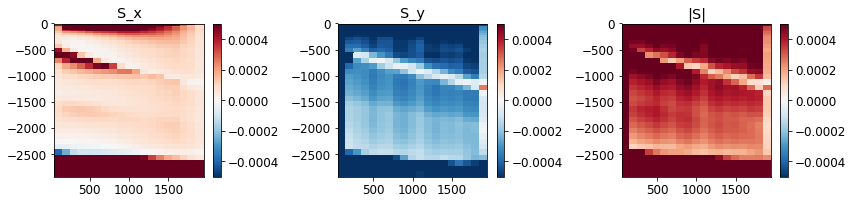

In [91]:
fig, ax = plt.subplots(1,3,figsize=(12,3))

im = ax[0].pcolormesh(Ycoarse/1e3, Z, T_coarse.Siso_X.sel(XCicoarse=slice(0,8)).mean('XCicoarse'),
                      vmin=-5e-4, vmax=5e-4, cmap='RdBu_r')
fig.colorbar(im, ax = ax[0])
ax[0].set_title('S_x')

im = ax[1].pcolormesh(Ycoarse/1e3, Z, T_coarse.Siso_Y.sel(XCicoarse=slice(0,8)).mean('XCicoarse'),
                      vmin=-5e-4, vmax=5e-4, cmap='RdBu_r')
fig.colorbar(im, ax = ax[1])
ax[1].set_title('S_y')

im = ax[2].pcolormesh(Ycoarse/1e3, Z, ((T_coarse.Siso_Y**2 + T_coarse.Siso_X**2)**0.5  ).sel(XCicoarse=slice(0,8)).mean('XCicoarse'),
                      vmin=-5e-4, vmax=5e-4, cmap='RdBu_r')
fig.colorbar(im, ax = ax[2])
ax[2].set_title('|S|')

plt.tight_layout()

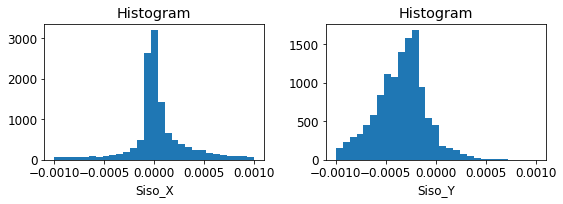

In [204]:
bins = np.linspace(-1,1,30)*1e-3

plt.figure(figsize=(8,3))
plt.subplot(121)
T_coarse.Siso_X.plot.hist(bins =bins)


plt.subplot(122)
T_coarse.Siso_Y.plot.hist(bins =bins)

plt.tight_layout()

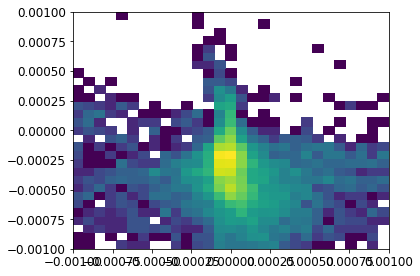

In [213]:
plt.hist2d(T_coarse.Siso_X.values.reshape(-1), T_coarse.Siso_Y.values.reshape(-1), bins=[bins,bins],norm= colors.LogNorm())
plt.xlim([-1e-3, 1e-3])
plt.ylim([-1e-3, 1e-3])

plt.tight_layout()

In [ ]:
## Kgm from only psi 2 
# Actually we get negative values if we look at the region that is upstream ... hmmm ???
# What happens if we naively use buoyancy fluxes to estimate Kgm (like can be done for zonal case?)

## What fraction of the tracer fluxes are captured by different parts of the tensor? 

In [186]:
# Naive attempt to calculate Kgm 
KgmY =  AT.isel(i=2, j=1)/T_coarse.Siso_Y
KgmX = AT.isel(i=2, j=0)/T_coarse.Siso_X

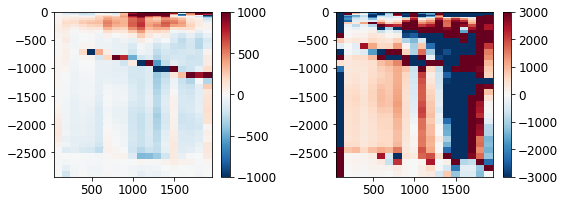

In [195]:
fig, ax = plt.subplots(1,2, figsize=(8,3))


im = ax[0].pcolormesh(Ycoarse/1e3, Z, KgmY.sel(XCicoarse=6).T, vmin=-1000, vmax=1000, cmap='RdBu_r')
fig.colorbar(im, ax=ax[0])

im = ax[1].pcolormesh(Ycoarse/1e3, Z, KgmX.sel(XCicoarse=6).T, vmin=-3000, vmax=3000, cmap='RdBu_r')
fig.colorbar(im, ax=ax[1])

plt.tight_layout()


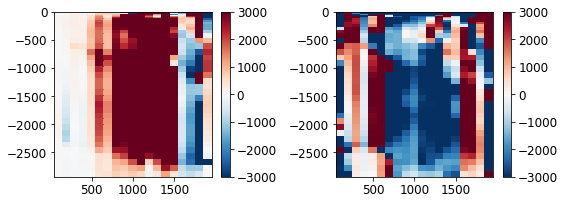

In [196]:
fig, ax = plt.subplots(1,2, figsize=(8,3))


im = ax[0].pcolormesh(Ycoarse/1e3, Z, KgmY.sel(XCicoarse=14).T, vmin=-3000, vmax=3000, cmap='RdBu_r')
fig.colorbar(im, ax=ax[0])

im = ax[1].pcolormesh(Ycoarse/1e3, Z, KgmX.sel(XCicoarse=14).T, vmin=-3000, vmax=3000, cmap='RdBu_r')
fig.colorbar(im, ax=ax[1])

plt.tight_layout()


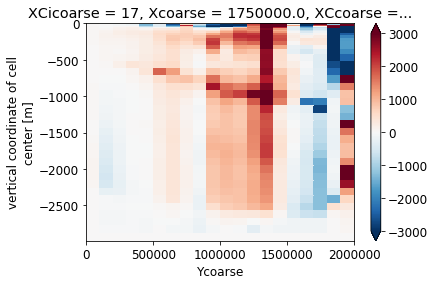

In [184]:
Kgm.sel(XCicoarse=17).plot(x='Ycoarse', y='Z', vmin=-3000)

# PV fluxes

Writing the PV fluxes in the EP flux form: 

$$ u'q' = (u'v')_x + (\frac{v'^2 - u'^2}{2})_y + \frac{(b'^2)_y}{2N^2} + (f_o \frac{u'b'}{N^2})_z$$

$$ v'q' = (\frac{v'^2 - u'^2}{2})_x - \frac{(b'^2)_x}{2N^2} +  -(u'v')_y +(f_o \frac{v'b'}{N^2})_z$$

In [363]:
# no spatial averaging
upvp = grid.interp(grid.interp(Model2_Tav.UVtave , 'X'), 'Y', boundary='extend') \
                   - Model_Tav.UmeanC*Model_Tav.VmeanC
vpvp = grid.interp(Model2_Tav.VVtave, 'Y', boundary='extend')  - Model_Tav.VmeanC**2
upup = grid.interp(Model2_Tav.UUtave, 'X') - Model_Tav.UmeanC**2

uptp = Model_Tav.UTtave - Model_Tav.UmeanC*Model_Tav.Ttave
vptp = Model_Tav.VTtave - Model_Tav.VmeanC*Model_Tav.Ttave

tptp = Model2_Tav.TTtave - Model_Tav.Ttave**2

N2 = -grid.interp(grid.diff(Model_Tav.Ttave, 'Z', boundary='extend'), 
                 'Z', boundary='extend')/Model_Tav.drF

In [364]:
dx = 5e3
dy = 5e3

In [365]:
g=9.81
alpha=2e-4

In [369]:
# upqp
upqp1 =  grid.interp(grid.diff(upvp, 'X')/dx ,'X')
upqp2 = 0.5*grid.interp( grid.diff(vpvp -upup, 'Y', boundary='extend')/dy, 
                    'Y', boundary='extend')
upqp3 = 0.5*g*alpha/N2*grid.interp(grid.diff(tptp, 'Y', boundary='extend')/dy,
                          'Y', boundary='extend')
upqp4 = -f0*grid.interp( grid.diff(uptp/N2 ,'Z', boundary='extend'),
                      'Z', boundary='extend')/Model_Tav.drF
upqp = upqp1 + upqp2 + upqp3 + upqp4

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1001: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:997: RuntimeWarning: invalid value encountered in add
  return 0.5*(data_left + data_right)


In [368]:
# vpqp
vpqp1 = 0.5*grid.interp( grid.diff(vpvp -upup, 'X')/dx,'X')
vpqp2 = -0.5*g*alpha/N2*grid.interp(grid.diff(tptp, 'X')/dx,'X')
vpqp3 = -grid.interp(grid.diff(upvp, 'Y', boundary='extend')/dy ,
                      'Y', boundary='extend')
vpqp4 = -f0*grid.interp( grid.diff(vptp/N2 ,'Z', boundary='extend'),
                      'Z', boundary='extend')/Model_Tav.drF
vpqp = vpqp1 + vpqp2 + vpqp3 + vpqp4

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1001: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:997: RuntimeWarning: invalid value encountered in add
  return 0.5*(data_left + data_right)


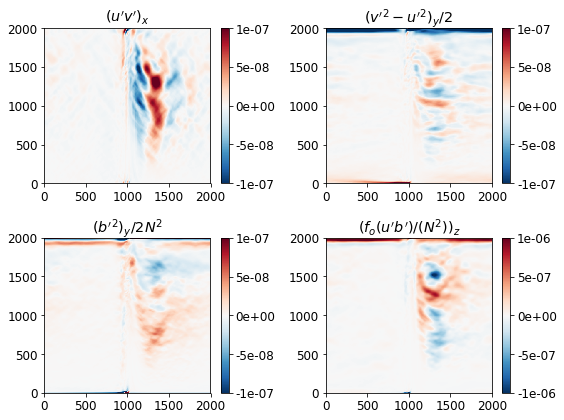

In [370]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

im = ax[0,0].pcolormesh(X/1e3, Y/1e3, upqp1.sel(Z=-1500, method='nearest') ,
                        vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
ax[0,0].set_title('$(u\'v\')_x$')
fig.colorbar(im, ax=ax[0,0], format='%.0e')

im = ax[0,1].pcolormesh(X/1e3, Y/1e3, upqp2.sel(Z=-1500, method='nearest') ,
                        vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
ax[0,1].set_title('$(v\'^2 - u\'^2)_y$/2 ')
fig.colorbar(im, ax=ax[0,1], format='%.0e')

im = ax[1,0].pcolormesh(X/1e3, Y/1e3, upqp3.sel(Z=-1500, method='nearest') ,
                        vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
ax[1,0].set_title('$(b\'^2)_y/2N^2$')
fig.colorbar(im, ax=ax[1,0], format='%.0e')

im = ax[1,1].pcolormesh(X/1e3, Y/1e3, upqp4.sel(Z=-1500, method='nearest') ,
                        vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')
ax[1,1].set_title('$(f_o (u\'b\')/(N^2))_z$')

fig.colorbar(im, ax=ax[1,1], format='%.0e')

plt.tight_layout()

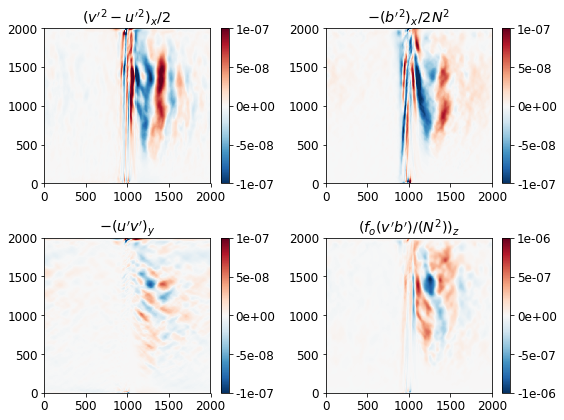

In [372]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

im = ax[0,0].pcolormesh(X/1e3, Y/1e3, vpqp1.sel(Z=-1500, method='nearest') ,
                        vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
ax[0,0].set_title('$(v\'^2 - u\'^2)_x$/2 ')
fig.colorbar(im, ax=ax[0,0], format='%.0e')

im = ax[0,1].pcolormesh(X/1e3, Y/1e3, vpqp2.sel(Z=-1500, method='nearest') ,
                        vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
ax[0,1].set_title('$-(b\'^2)_x/2N^2$')
fig.colorbar(im, ax=ax[0,1], format='%.0e')

im = ax[1,0].pcolormesh(X/1e3, Y/1e3, vpqp3.sel(Z=-1500, method='nearest') ,
                        vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
ax[1,0].set_title('$-(u\'v\')_y$')
fig.colorbar(im, ax=ax[1,0], format='%.0e')

im = ax[1,1].pcolormesh(X/1e3, Y/1e3, vpqp4.sel(Z=-1500, method='nearest') ,
                        vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')
ax[1,1].set_title('$(f_o (v\'b\')/(N^2))_z$')

fig.colorbar(im, ax=ax[1,1], format='%.0e')

plt.tight_layout()

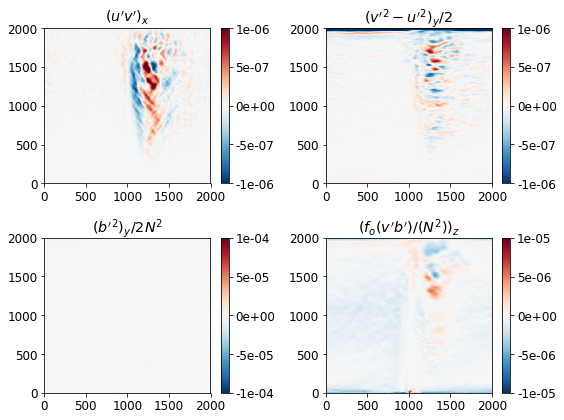

In [373]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

im = ax[0,0].pcolormesh(X/1e3, Y/1e3, upqp1.sel(Z=-200, method='nearest') ,
                        vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')
ax[0,0].set_title('$(u\'v\')_x$')
fig.colorbar(im, ax=ax[0,0], format='%.0e')

im = ax[0,1].pcolormesh(X/1e3, Y/1e3, upqp2.sel(Z=-200, method='nearest') ,
                        vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')
ax[0,1].set_title('$(v\'^2 - u\'^2)_y$/2 ')
fig.colorbar(im, ax=ax[0,1], format='%.0e')

im = ax[1,0].pcolormesh(X/1e3, Y/1e3, upqp3.sel(Z=-200, method='nearest') ,
                        vmin=-1e-4, vmax=1e-4, cmap='RdBu_r')
ax[1,0].set_title('$(b\'^2)_y/2N^2$')
fig.colorbar(im, ax=ax[1,0], format='%.0e')

im = ax[1,1].pcolormesh(X/1e3, Y/1e3, upqp4.sel(Z=-200, method='nearest') ,
                        vmin=-1e-5, vmax=1e-5, cmap='RdBu_r')
ax[1,1].set_title('$(f_o (v\'b\')/(N^2))_z$')

fig.colorbar(im, ax=ax[1,1], format='%.0e')

plt.tight_layout()

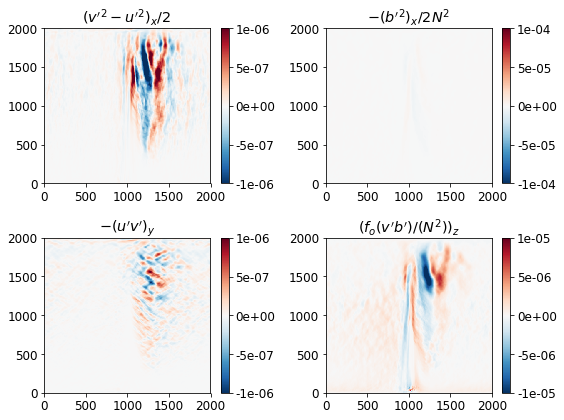

In [374]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

im = ax[0,0].pcolormesh(X/1e3, Y/1e3, vpqp1.sel(Z=-200, method='nearest') ,
                        vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')
ax[0,0].set_title('$(v\'^2 - u\'^2)_x$/2 ')
fig.colorbar(im, ax=ax[0,0], format='%.0e')

im = ax[0,1].pcolormesh(X/1e3, Y/1e3, vpqp2.sel(Z=-200, method='nearest') ,
                        vmin=-1e-4, vmax=1e-4, cmap='RdBu_r')
ax[0,1].set_title('$-(b\'^2)_x/2N^2$')
fig.colorbar(im, ax=ax[0,1], format='%.0e')

im = ax[1,0].pcolormesh(X/1e3, Y/1e3, vpqp3.sel(Z=-200, method='nearest') ,
                        vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')
ax[1,0].set_title('$-(u\'v\')_y$')
fig.colorbar(im, ax=ax[1,0], format='%.0e')

im = ax[1,1].pcolormesh(X/1e3, Y/1e3, vpqp4.sel(Z=-200, method='nearest') ,
                        vmin=-1e-5, vmax=1e-5, cmap='RdBu_r')
ax[1,1].set_title('$(f_o (v\'b\')/(N^2))_z$')

fig.colorbar(im, ax=ax[1,1], format='%.0e')

plt.tight_layout()

## PV fluxes

EP fluxes in 3D 

* for now lets ignore the momentum flux parts 

In [228]:
f0= -1.1e-4 
beta = 1.4e-11

In [378]:
PV = xr.Dataset()

PV['uq'] = -grid.interp( grid.diff(f0/ T_coarse['T_Z'] * T_coarse.UpTp , 'Z', boundary='extend'),
                             'Z', boundary='extend')/ T_coarse.drF

PV['vq'] = -grid.interp( grid.diff(f0/ T_coarse['T_Z'] * T_coarse.VpTp , 'Z', boundary='extend'), 
                             'Z', boundary='extend')/ T_coarse.drF

In [400]:
PV['recuq'] = -grid.interp( grid.diff(f0/ T_coarse['T_Z'] * (-recUB_corr) , 'Z', boundary='extend'),
                             'Z', boundary='extend')/ T_coarse.drF

PV['recvq'] = -grid.interp( grid.diff(f0/ T_coarse['T_Z'] * (-recVB_corr) , 'Z', boundary='extend'), 
                             'Z', boundary='extend')/ T_coarse.drF

In [379]:
# Y gradient of QGPV
PV['Q_X'] =   f0* grid.interp( grid.diff(T_coarse.Siso_X,'Z', boundary='extend'),
                               'Z', boundary='extend')/ T_coarse.drF
PV['Q_Y'] = beta  + f0*grid.interp( grid.diff(T_coarse.Siso_Y,'Z', boundary='extend'),
                               'Z', boundary='extend')/ T_coarse.drF

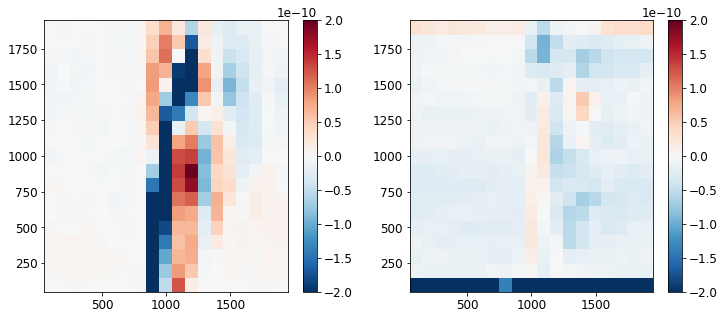

In [381]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

im = ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, PV.Q_X.sel(Z=-1500, method='nearest'), 
               vmin=-2e-10, vmax=2e-10, cmap='RdBu_r')
fig.colorbar(im,  ax= ax[0])

im = ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, PV.Q_Y.sel(Z=-1500, method='nearest'), 
               vmin=-2e-10, vmax=2e-10, cmap='RdBu_r')
fig.colorbar(im,  ax= ax[1])


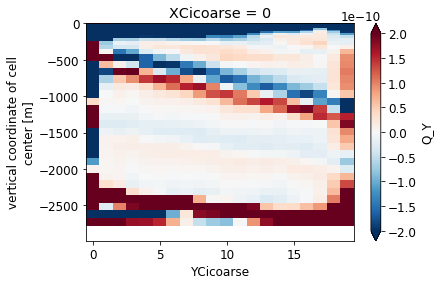

In [383]:
PV.Q_Y.sel(XCicoarse=0).plot(vmin=-2e-10)

In [384]:
# Recreate PV flux 

# we are not using the Z component (QG)

recUQ_corr = Ktensor_corr.sel(i=0, j=0)*PV.Q_X + \
             Ktensor_corr.sel(i=0, j=1)*PV.Q_Y 

recVQ_corr = Ktensor_corr.sel(i=1, j=0)*PV.Q_X + \
             Ktensor_corr.sel(i=1, j=1)*PV.Q_Y 

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


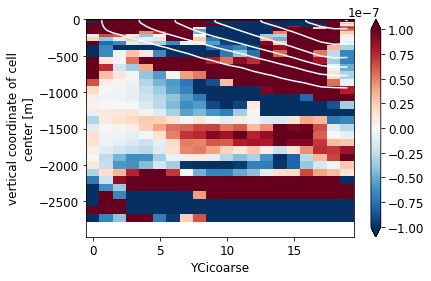

In [385]:
(-recVQ_corr).mean('XCicoarse').plot(x='YCicoarse', y='Z',vmin=-1e-7)
T_coarse['T'].mean('XCicoarse').plot.contour(levels=np.linspace(0,8,9), colors='w')

Text(0.5, 1.0, 'upqp _ using eddy T flux fine')

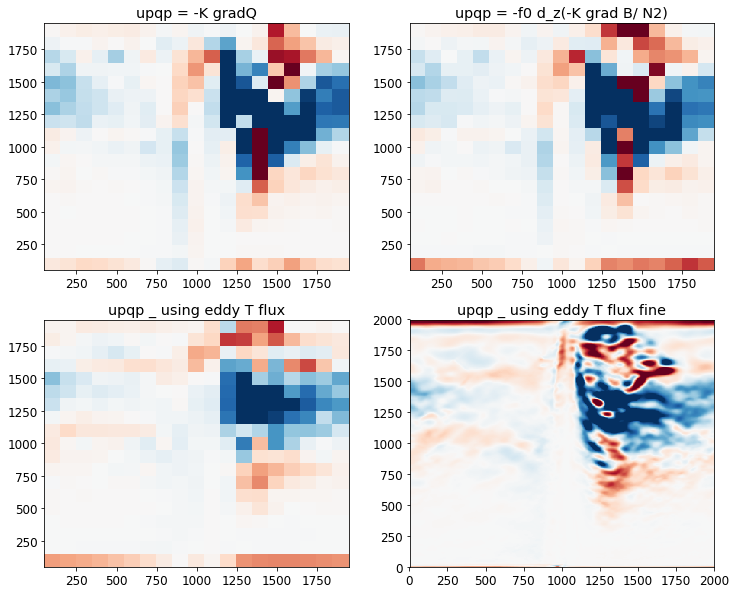

In [405]:
fig , ax = plt.subplots(2,2, figsize=(12,10))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (-recUQ_corr).sel(Z=-1000, method='nearest').T ,
                 vmin=-1e-6,vmax=1e-6, cmap='RdBu_r')
ax[0,0].set_title('upqp = -K gradQ')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (PV.recuq).sel(Z=-1000, method='nearest') ,
                 vmin=-1e-6,vmax=1e-6, cmap='RdBu_r')
ax[0,1].set_title('upqp = -f0 d_z(-K grad B/ N2)')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (PV.uq).sel(Z=-1000, method='nearest') ,
                 vmin=-1e-6,vmax=1e-6, cmap='RdBu_r')
ax[1,0].set_title('upqp _ using eddy T flux')

ax[1,1].pcolormesh(X/1e3, Y/1e3, (upqp).sel(Z=-1000, method='nearest') ,
                 vmin=-1e-6,vmax=1e-6, cmap='RdBu_r')
ax[1,1].set_title('upqp _ using eddy T flux fine')

Text(0.5, 1.0, 'vpqp _ using eddy T flux fine')

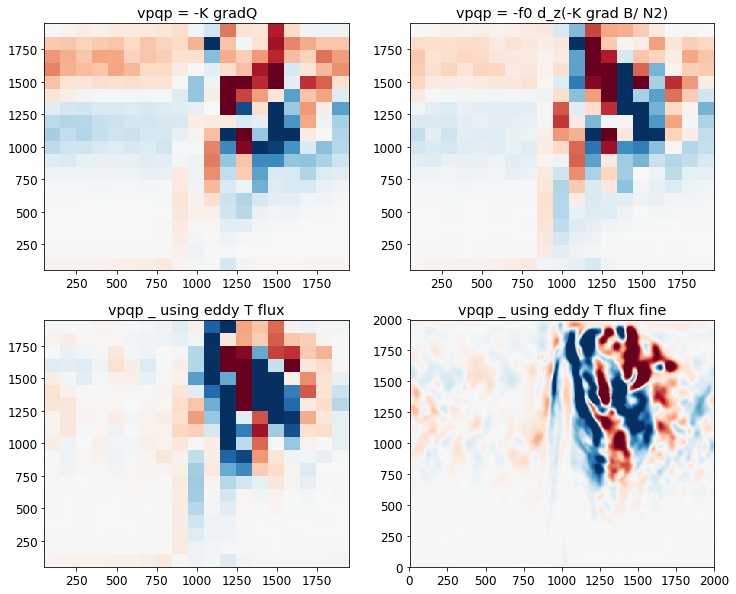

In [407]:
fig , ax = plt.subplots(2,2, figsize=(12,10))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (-recVQ_corr).sel(Z=-1000, method='nearest').T ,
                 vmin=-1e-6,vmax=1e-6, cmap='RdBu_r')
ax[0,0].set_title('vpqp = -K gradQ')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (PV.recvq).sel(Z=-1000, method='nearest') ,
                 vmin=-1e-6,vmax=1e-6, cmap='RdBu_r')
ax[0,1].set_title('vpqp = -f0 d_z(-K grad B/ N2)')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (PV.vq).sel(Z=-1000, method='nearest') ,
                 vmin=-1e-6,vmax=1e-6, cmap='RdBu_r')
ax[1,0].set_title('vpqp _ using eddy T flux')

ax[1,1].pcolormesh(X/1e3, Y/1e3, (vpqp).sel(Z=-1000, method='nearest') ,
                 vmin=-1e-6,vmax=1e-6, cmap='RdBu_r')
ax[1,1].set_title('vpqp _ using eddy T flux fine')

Text(0.5, 1.0, 'upqp _ using eddy T flux fine')

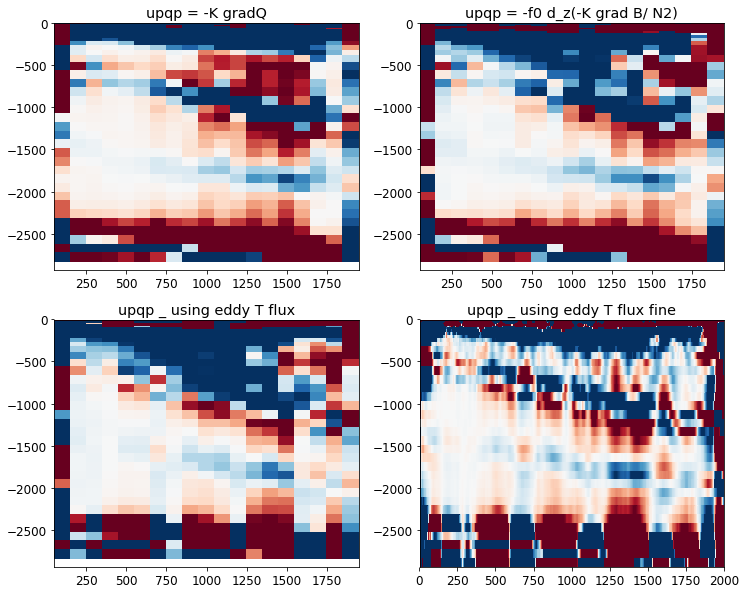

In [410]:
fig , ax = plt.subplots(2,2, figsize=(12,10))

ax[0,0].pcolormesh(Ycoarse/1e3, Z, (-recUQ_corr).sel(XCicoarse=0, method='nearest').T ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r')
ax[0,0].set_title('upqp = -K gradQ')

ax[0,1].pcolormesh(Ycoarse/1e3, Z, (PV.recuq).sel(XCicoarse=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r')
ax[0,1].set_title('upqp = -f0 d_z(-K grad B/ N2)')

ax[1,0].pcolormesh(Ycoarse/1e3, Z, (PV.uq).sel(XCicoarse=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r')
ax[1,0].set_title('upqp _ using eddy T flux')

ax[1,1].pcolormesh(Y/1e3, Z, (upqp).sel(XC=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r')
ax[1,1].set_title('upqp _ using eddy T flux fine')

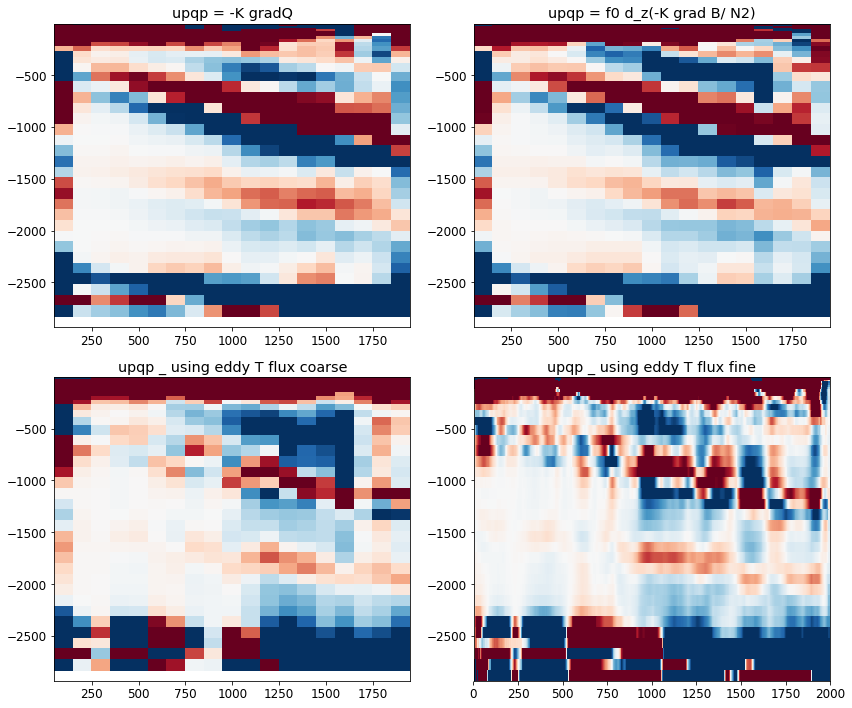

In [417]:
fig , ax = plt.subplots(2,2, figsize=(12,10))

ax[0,0].pcolormesh(Ycoarse/1e3, Z, (-recVQ_corr).sel(XCicoarse=0, method='nearest').T ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r')
ax[0,0].set_title('upqp = -K gradQ')

ax[0,1].pcolormesh(Ycoarse/1e3, Z, (PV.recvq).sel(XCicoarse=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r')
ax[0,1].set_title('upqp = f0 d_z(-K grad B/ N2)')

ax[1,0].pcolormesh(Ycoarse/1e3, Z, (PV.vq).sel(XCicoarse=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r')
ax[1,0].set_title('upqp _ using eddy T flux coarse')

ax[1,1].pcolormesh(Y/1e3, Z, (vpqp).sel(XC=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r')
ax[1,1].set_title('upqp _ using eddy T flux fine')

plt.tight_layout()

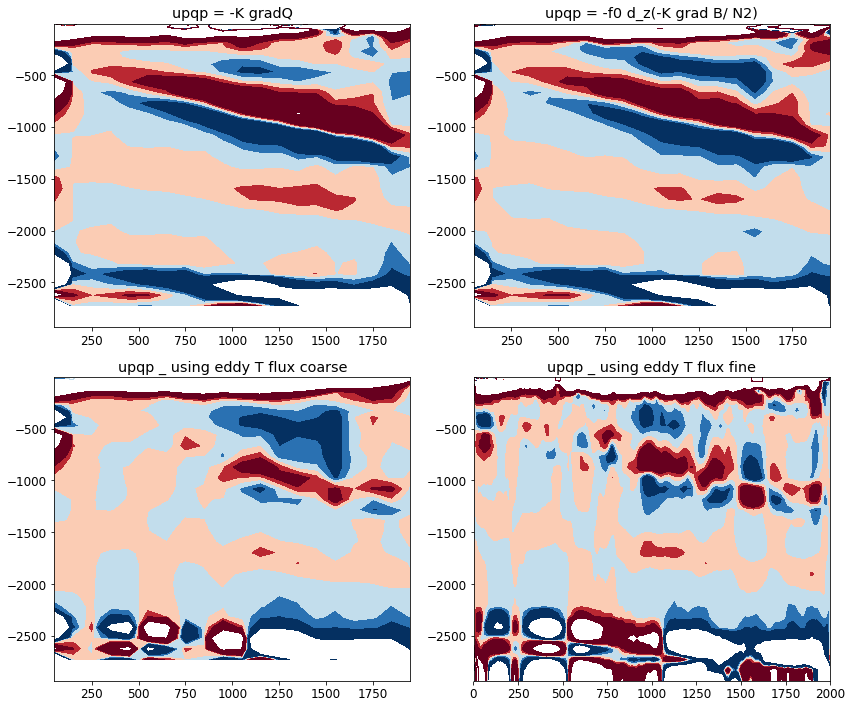

In [416]:
fig , ax = plt.subplots(2,2, figsize=(12,10))
levels = np.linspace(-5e-7, 5e-7,21)

ax[0,0].contourf(Ycoarse/1e3, Z, (-recVQ_corr).sel(XCicoarse=0, method='nearest').T ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[0,0].set_title('upqp = -K gradQ')

ax[0,1].contourf(Ycoarse/1e3, Z, (PV.recvq).sel(XCicoarse=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[0,1].set_title('upqp = -f0 d_z(-K grad B/ N2)')

ax[1,0].contourf(Ycoarse/1e3, Z, (PV.vq).sel(XCicoarse=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[1,0].set_title('upqp _ using eddy T flux coarse')

ax[1,1].contourf(Y/1e3, Z, (vpqp).sel(XC=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[1,1].set_title('upqp _ using eddy T flux fine')

plt.tight_layout()

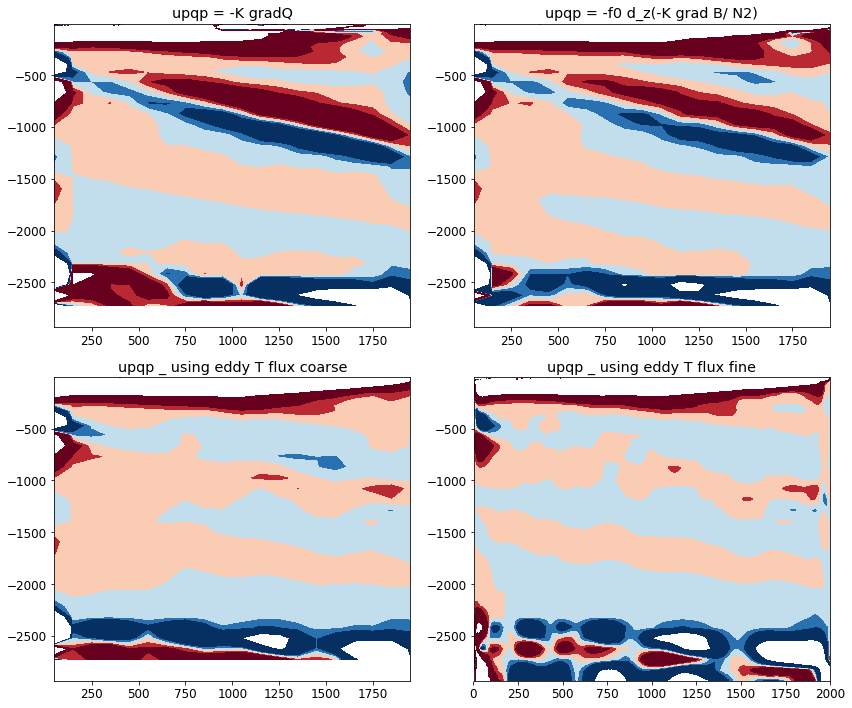

In [421]:
fig , ax = plt.subplots(2,2, figsize=(12,10))
levels = np.linspace(-5e-7, 5e-7,21)

ax[0,0].contourf(Ycoarse/1e3, Z, (-recVQ_corr).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[0,0].set_title('upqp = -K gradQ')

ax[0,1].contourf(Ycoarse/1e3, Z, (PV.recvq).sel(XCicoarse=slice(0,8)).mean('XCicoarse') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[0,1].set_title('upqp = -f0 d_z(-K grad B/ N2)')

ax[1,0].contourf(Ycoarse/1e3, Z, (PV.vq).sel(XCicoarse=slice(0,8)).mean('XCicoarse') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[1,0].set_title('upqp _ using eddy T flux coarse')

ax[1,1].contourf(Y/1e3, Z, (vpqp).sel(XC=slice(0,800e3)).mean('XC') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[1,1].set_title('upqp _ using eddy T flux fine')

plt.tight_layout()

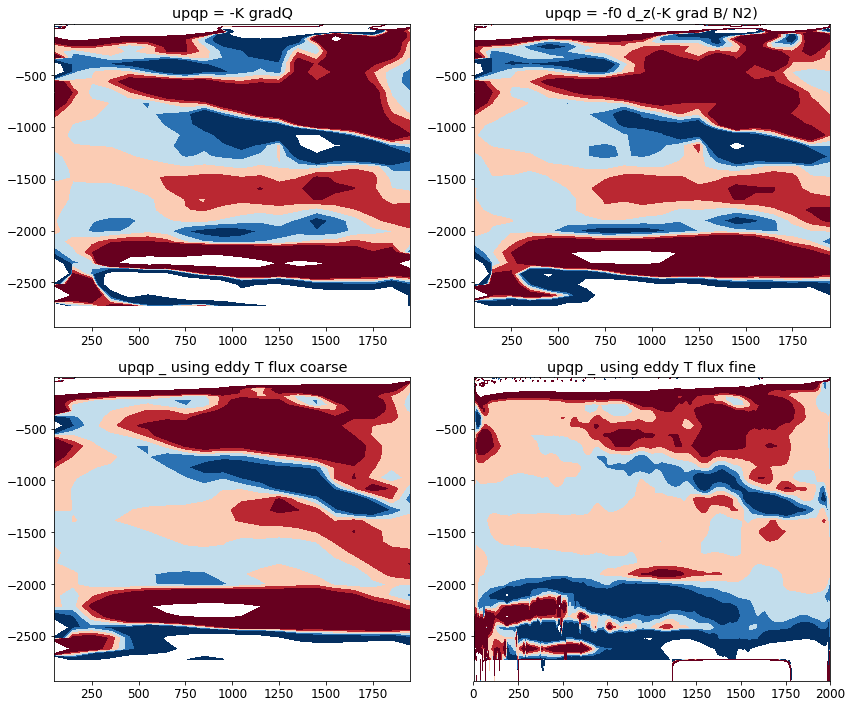

In [422]:
fig , ax = plt.subplots(2,2, figsize=(12,10))

levelsT = np.array([0,0.2,0.4,0.6,0.8, 1, 3, 5,7])
levels = np.linspace(-5e-7, 5e-7,21)

ax[0,0].contourf(Ycoarse/1e3, Z, (-recVQ_corr).sel(XCicoarse=slice(0,20)).mean('XCicoarse').T ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[0,0].set_title('upqp = -K gradQ')

ax[0,1].contourf(Ycoarse/1e3, Z, (PV.recvq).sel(XCicoarse=slice(0,20)).mean('XCicoarse') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[0,1].set_title('upqp = -f0 d_z(-K grad B/ N2)')

ax[1,0].contourf(Ycoarse/1e3, Z, (PV.vq).sel(XCicoarse=slice(0,20)).mean('XCicoarse') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[1,0].set_title('upqp _ using eddy T flux coarse')

ax[1,1].contourf(Y/1e3, Z, (vpqp).sel(XC=slice(0,2000e3)).mean('XC') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[1,1].set_title('upqp _ using eddy T flux fine')

plt.tight_layout()

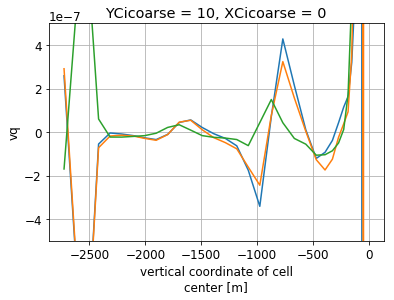

In [429]:
(-recVQ_corr).sel(XCicoarse=0, YCicoarse=10).plot()
PV.recvq.sel(XCicoarse=0, YCicoarse=10).plot()
PV.vq.sel(XCicoarse=0, YCicoarse=10).plot()
plt.ylim([-5e-7, 5e-7])
plt.grid()

PV fluxes are not apparently downgradient. Specially downstream region. 

## Buoyancy fluxes

How well can we use buoyancy fluxes to determine the Kgm? Specially in 3D. Issues of Rotational fluxes an issue? Some of this learning can be applied to the observations (where Argo are providing estimates of v'b'). 

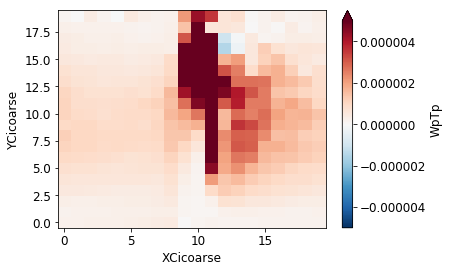

In [167]:
T_coarse.WpTp.mean('Z').plot(vmin=-5e-6)

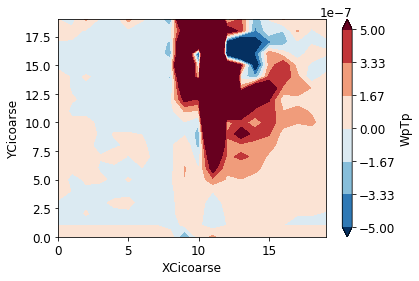

In [168]:
T_coarse.WpTp.sel(Z=slice(-600, -2000)).mean('Z').plot.contourf(vmin=-5e-7)

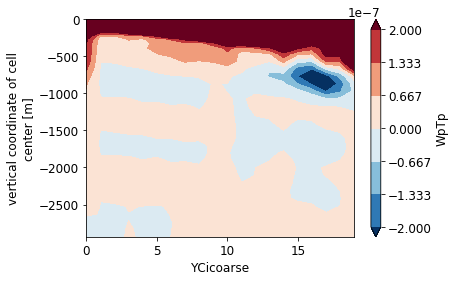

In [102]:

T_coarse.WpTp.isel(XCicoarse=slice(0,8)).mean('XCicoarse').plot.contourf(vmin=-2e-7)


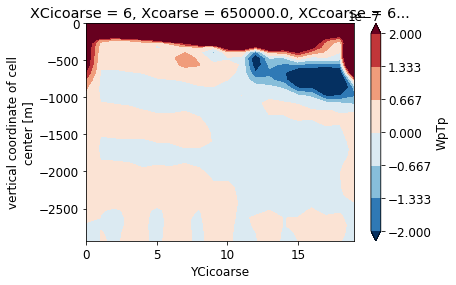

In [175]:
T_coarse.WpTp.isel(XCicoarse=6).plot.contourf(vmin=-2e-7)


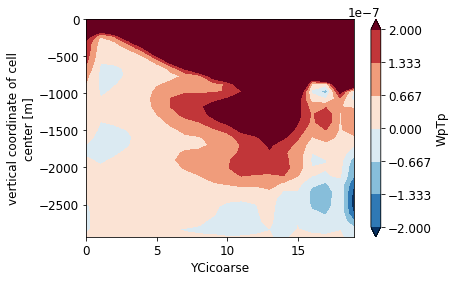

In [336]:
T_coarse.WpTp.isel(XCicoarse=slice(0,20)).mean('XCicoarse').plot.contourf(vmin=-2e-7)